# Modeling elections

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 4 columns, representing Clinton, Trump, Johnson, and Stein in that order. In the example below, Clinton got 340 votes in the first survey, Trump got 258, Johnson got 27, and Stein got 13.
```
  >>> survey_results['Indiana']
  array([[340, 258,  27,  13],
         [240, 155,   5,   5],
         [235, 155,  50,  20],
         [308, 266,  49,  35],
         [222, 161,  80,  30]])
```
Data from [Wikipedia: Statewide opinion polling for the United States presidential election, 2016](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_United_States_presidential_election,_2016)


In [2]:
electoral_votes = {
    'California': 55, 'Texas': 38, 'Florida': 29, 'New York': 29, 'Illinois': 20,
    'Pennsylvania': 20, 'Ohio': 18, 'Georgia': 16, 'Michigan': 16,
    'North Carolina': 15, 'New Jersey': 14, 'Virginia': 13, 'Washington': 12,
    'Arizona': 11, 'Indiana': 11, 'Massachusetts': 11, 'Tennessee': 11,
    'Maryland': 10, 'Minnesota': 10, 'Missouri': 10, 'Wisconsin': 10, 'Alabama': 9,
    'Colorado': 9, 'South Carolina': 9, 'Kentucky': 8, 'Louisiana': 8,
    'Connecticut': 7, 'Oklahoma': 7, 'Oregon': 7, 'Arkansas': 6, 'Iowa': 6,
    'Kansas': 6, 'Mississippi': 6, 'Nevada': 6, 'Utah': 6, 'Nebraska': 5,
    'New Mexico': 5, 'West Virginia': 5, 'Hawaii': 4, 'Idaho': 4, 'Maine': 4,
    'New Hampshire': 4, 'Rhode Island': 4, 'Alaska': 3, 'Delaware': 3,
    'District of Columbia': 3, 'Montana': 3, 'North Dakota': 3, 'South Dakota': 3,
    'Vermont': 3, 'Wyoming': 3}

survey_results = {
    'Alabama': np.array([], dtype=int).reshape(0, 4),
    'Alaska': np.array([400 * np.array([.47, .43, .07, .03]), 500 * np.array([.36, .37, .07, .03]), 500 * np.array([.34, .37, .10, .02]), 660 * np.array([.31, .36, .18, .06])], dtype=int),
    'Arizona': np.array([392 * np.array([.45, .47, .05, .02]), 550 * np.array([.39, .47, .04, .03]), 719 * np.array([.40, .45, .09, .03]), 769 * np.array([.44, .49, .05, .01]), 2229 * np.array([.45, .44, .07, .01]), 700 * np.array([.43, .47, .02, .02]), 550 * np.array([.41, .45, .03, .01]), 994 * np.array([.42, .44, .04, .01]), 550 * np.array([.40, .42, .05, .02]), 2385 * np.array([.48, .46, .05, .01]), 401 * np.array([.45, .46, .04, .01]), 550 * np.array([.41, .41, .05, .02]), 1538 * np.array([.39, .44, .06, .02]), 713 * np.array([.43, .38, .06, .01]), 400 * np.array([.39, .37, .08, .03]), 600 * np.array([.44, .42, .09, .01]), 718 * np.array([.42, .42, .05, .01]), 484 * np.array([.41, .46, .09, .01]), 649 * np.array([.38, .40, .12, .03])], dtype=int),
    'Arkansas': np.array([463 * np.array([.33, .56, .04, .02]), 831 * np.array([.34, .55, .03, .01]), 600 * np.array([.29, .57, .05, .03])], dtype=int),
    'California': np.array([401 * np.array([.58, .35, .03, .02]), 747 * np.array([.56, .35, .04, .01]), 1365 * np.array([.54, .30, .04, .03]), 1498 * np.array([.53, .33, .04, .03]), 1704 * np.array([.54, .28, .05, .05]), 725 * np.array([.56, .30, .04, .02]), 1250 * np.array([.54, .30, .04, .03]), 622 * np.array([.61, .25, .04, .03]), 732 * np.array([.59, .33, .03, .02]), 1055 * np.array([.47, .31, .10, .05]), 515 * np.array([.62, .34, .02, .01]), 1426 * np.array([.50, .33, .05, .06]), 678 * np.array([.57, .32, .03, .01]), 4212 * np.array([.49, .29, .11, .06])], dtype=int),
    'Colorado': np.array([1150 * np.array([.45, .44, .05, .04]), 500 * np.array([.44, .38, .07, .02]), 550 * np.array([.39, .39, .05, .04]), 750 * np.array([.44, .41, .08, .04]), 685 * np.array([.45, .37, .10, .03]), 400 * np.array([.49, .38, .07, .03]), 602 * np.array([.44, .33, .10, .03]), 694 * np.array([.46, .40, .06, .02]), 784 * np.array([.41, .42, .13, .03]), 991 * np.array([.40, .39, .07, .02]), 644 * np.array([.44, .42, .10, .02]), 540 * np.array([.41, .34, .12, .03]), 600 * np.array([.38, .42, .13, .02]), 704 * np.array([.48, .43, .04, .02]), 605 * np.array([.43, .38, .07, .02]), 997 * np.array([.42, .39, .07, .02])], dtype=int),
    'Connecticut': np.array([1000 * np.array([.50 , .35 , .09 , .04])], dtype=int),
    'Delaware': np.array([762 * np.array([.51 , .30 , .07 , .02])], dtype=int),
    'District of Columbia': np.array([], dtype=int).reshape(0, 4),
    'Florida': np.array([1100 * np.array([.46, .50, .02, .01]), 884 * np.array([.46, .45, .02, .01]), 1188 * np.array([.45, .45, .04, .02]), 603 * np.array([.49, .45, .03, .01]), 773 * np.array([.49, .47, .03, .01]), 626 * np.array([.46, .45, .02, .02]), 1995 * np.array([.49, .46, .02, .01]), 1150 * np.array([.45, .49, .02, .01]), 718 * np.array([.48, .40, .03, .02]), 500 * np.array([.46, .45, .04, .00]), 814 * np.array([.42, .46, .04, .02]), 779 * np.array([.45, .44, .05, .02]), 698 * np.array([.42, .46, .02, .01]), 1028 * np.array([.50, .37, .05, .01]), 836 * np.array([.43, .39, .06, .03]), 953 * np.array([.43, .45, .04, .02]), 1251 * np.array([.48, .45, .02, .01]), 500 * np.array([.46, .43, .03, .02]), 1042 * np.array([.46, .43, .03, .02]), 538 * np.array([.49, .45, .03, .02]), 507 * np.array([.46, .42, .05, .01]), 660 * np.array([.48, .44, .04, .01]), 985 * np.array([.46, .42, .05, .01]), 1532 * np.array([.42, .38, .06, .02]), 533 * np.array([.47, .44, .05, .01]), 400 * np.array([.49, .43, .01, .00]), 700 * np.array([.45, .42, .05, .03]), 600 * np.array([.44, .45, .04, .03]), 696 * np.array([.41, .38, .06, .03]), 545 * np.array([.46, .41, .05, .02]), 619 * np.array([.47, .46, .04, .02]), 820 * np.array([.46, .42, .07, .01]), 826 * np.array([.45, .43, .03, .01]), 500 * np.array([.44, .45, .03, .01]), 400 * np.array([.46, .41, .06, .01]), 502 * np.array([.49, .44, .06, .02]), 867 * np.array([.41, .40, .09, .02]), 788 * np.array([.44, .47, .06, .01]), 1193 * np.array([.44, .42, .05, .02]), 781 * np.array([.42, .46, .03, .01]), 744 * np.array([.43, .44, .05, .01])], dtype=int),
    'Georgia': np.array([1250 * np.array([.45, .52, .02, .00]), 650 * np.array([.42, .51, .02, .03]), 600 * np.array([.39, .45, .06, .03])], dtype=int),
    'Hawaii': np.array([], dtype=int).reshape(0, 4),
    'Idaho': np.array([608 * np.array([.30 , .40 , .10 , .03])], dtype=int),
    'Illinois': np.array([500 * np.array([.53, .41, .02, .00]), 600 * np.array([.45, .34, .06, .02]), 1200 * np.array([.51, .36, .06, .02]), 664 * np.array([.50, .32, .06, .01]), 865 * np.array([.53, .28, .05, .02]), 1200 * np.array([.49, .35, .04, .01]), 700 * np.array([.45, .39, .06, .03]), 600 * np.array([.43, .30, .08, .03]), 955 * np.array([.51, .33, .04, .01])], dtype=int),
    'Indiana': np.array([1313 * np.array([.36, .44, .10, .03])], dtype=int),
    'Iowa': np.array([800 * np.array([.39 , .46 , .06 , .01]), 700 * np.array([.41 , .44 , .05 , .04]), 500 * np.array([.44 , .43 , .03 , .03]), 791 * np.array([.44 , .44 , .04 , .01]), 800 * np.array([.39 , .43 , .06 , .02]), 491 * np.array([.38 , .38 , .09 , .01]), 612 * np.array([.37 , .44 , .10 , .02]), 404 * np.array([.37 , .45 , .08 , .02]), 1054 * np.array([.39 , .40 , .10 , .03]), 1076 * np.array([.41 , .44 , .05 , .02])], dtype=int),
    'Kansas': np.array([624 * np.array([.38 , .49 , .07 , .01]), 581 * np.array([.36 , .47 , .07 , .02]), 595 * np.array([.36 , .48 , .08 , .02])], dtype=int),
    'Kentucky': np.array([602 * np.array([.37 , .54 , .01 , .01]), 602 * np.array([.37 , .54 , .01 , .01])], dtype=int),
    'Louisiana': np.array([603 * np.array([.35 , .49 , .07 , .02]), 625 * np.array([.34 , .54 , .02 , .01]), 800 * np.array([.38 , .45 , .04 , .01]), 905 * np.array([.35 , .45 , .06 , .02])], dtype=int),
    'Maine': np.array([855 * np.array([.45 , .39 , .07 , .04]), 750 * np.array([.46 , .42 , .12 , .02]), 812 * np.array([.42 , .37 , .09 , .04]), 670 * np.array([.48 , .37 , .05 , .03]), 890 * np.array([.42 , .36 , .09 , .04]), 892 * np.array([.44 , .36 , .09 , .03]), 513 * np.array([.40 , .36 , .12 , .03]), 835 * np.array([.37 , .37 , .11 , .05]), 779 * np.array([.42 , .39 , .09 , .05]), 800 * np.array([.44 , .35 , .12 , .02])], dtype=int),
    'Maryland': np.array([706 * np.array([.63, .27, .04, .02]), 514 * np.array([.58, .25, .06, .02])], dtype=int),
    'Massachusetts': np.array([417 * np.array([.56, .26, .08, .03]), 500 * np.array([.57, .25, .04, .03]), 502 * np.array([.54, .28, .07, .03]), 403 * np.array([.58, .26, .07, .04]), 700 * np.array([.47, .34, .09, .03]), 500 * np.array([.54, .28, .09, .04]), 500 * np.array([.50, .33, .09, .02])], dtype=int),
    'Michigan': np.array([1200 * np.array([.47, .49, .03, .01]), 957 * np.array([.46, .41, .06, .02]), 573 * np.array([.44, .44, .04, .03]), 1007 * np.array([.46, .41, .07, .03]), 600 * np.array([.42, .38, .05, .02]), 1150 * np.array([.47, .44, .04, .03]), 887 * np.array([.47, .44, .04, .03]), 737 * np.array([.50, .43, .04, .01]), 953 * np.array([.47, .41, .06, .02]), 500 * np.array([.45, .44, .05, .02]), 746 * np.array([.47, .28, .11, .04]), 500 * np.array([.50, .43, .03, .03]), 1030 * np.array([.48, .42, .05, .01]), 600 * np.array([.41, .34, .09, .03]), 1241 * np.array([.49, .41, .03, .01]), 600 * np.array([.41, .36, .07, .03]), 1102 * np.array([.51, .38, .06, .02]), 1370 * np.array([.40, .36, .07, .02]), 1429 * np.array([.47, .37, .07, .04]), 600 * np.array([.42, .31, .10, .05]), 600 * np.array([.43, .32, .10, .03]), 600 * np.array([.42, .35, .09, .03]), 1956 * np.array([.46, .41, .08, .01]), 600 * np.array([.38, .35, .10, .04]), 940 * np.array([.45, .39, .07, .01])], dtype=int),
    'Minnesota': np.array([656 * np.array([.49, .39, .05, .02]), 625 * np.array([.46, .39, .06, .02]), 625 * np.array([.44, .38, .06, .02]), 625 * np.array([.47, .39, .06, .01])], dtype=int),
    'Mississippi': np.array([], dtype=int).reshape(0, 4),
    'Missouri': np.array([750 * np.array([.41, .47, .07, .02]), 871 * np.array([.37, .50, .04, .02]), 1722 * np.array([.39, .51, .04, .01]), 508 * np.array([.38, .47, .03, .01]), 650 * np.array([.37, .52, .05, .02]), 405 * np.array([.38, .52, .04, .02]), 625 * np.array([.42, .47, .03, .01]), 2559 * np.array([.39, .50, .04, .01]), 600 * np.array([.39, .47, .05, .02]), 2171 * np.array([.42, .47, .04, .01]), 406 * np.array([.41, .46, .05, .02]), 1087 * np.array([.37, .46, .05, .02]), 600 * np.array([.34, .47, .07, .06]), 1275 * np.array([.38, .47, .08, .03])], dtype=int),
    'Montana': np.array([590 * np.array([.27 , .43 , .07 , .02])], dtype=int),
    'Nebraska': np.array([700 * np.array([.29 , .56 , .07 , .01])], dtype=int),
    'Nevada': np.array([387 * np.array([.46 , .46 , .05 , .01]), 1158 * np.array([.45 , .43 , .04 , .03]), 600 * np.array([.47 , .46 , .04 , .01]), 1100 * np.array([.45 , .50 , .03 , .01]), 550 * np.array([.44 , .42 , .03 , .00]), 700 * np.array([.43 , .43 , .09 , .04]), 400 * np.array([.42 , .42 , .07 , .03]), 627 * np.array([.41 , .42 , .08 , .03])], dtype=int),
    'New Hampshire': np.array([701 * np.array([.49 , .38 , .06 , .01]), 1000 * np.array([.45 , .44 , .05 , .03]), 600 * np.array([.43 , .48 , .04 , .01]), 500 * np.array([.42 , .42 , .05 , .02]), 695 * np.array([.44 , .44 , .05 , .02]), 500 * np.array([.39 , .40 , .10 , .03]), 641 * np.array([.46 , .39 , .06 , .01]), 600 * np.array([.46 , .43 , .06 , .02]), 401 * np.array([.46 , .42 , .07 , .01]), 768 * np.array([.45 , .36 , .10 , .04]), 772 * np.array([.43 , .38 , .08 , .03]), 900 * np.array([.44 , .36 , .10 , .06]), 770 * np.array([.49 , .34 , .08 , .02]), 501 * np.array([.41 , .38 , .11 , .03]), 517 * np.array([.45 , .39 , .09 , .02]), 500 * np.array([.44 , .42 , .05 , .01]), 502 * np.array([.42 , .35 , .13 , .04]), 600 * np.array([.43 , .37 , .11 , .04]), 522 * np.array([.46 , .42 , .06 , .01]), 400 * np.array([.47 , .38 , .10 , .01]), 737 * np.array([.39 , .37 , .15 , .03]), 600 * np.array([.42 , .37 , .14 , .04]), 408 * np.array([.43 , .45 , .04 , .02])], dtype=int),
    'New Jersey': np.array([678 * np.array([.51, .40, .03, .01]), 293 * np.array([.49, .35, .06, .04]), 735 * np.array([.50, .29, .06, .04]), 800 * np.array([.47, .43, .05, .02])], dtype=int),
    'New Mexico': np.array([8439 * np.array([.46 , .44 , .06 , .01]), 504 * np.array([.45 , .40 , .11 , .03]), 1102 * np.array([.46 , .43 , .07 , .01]), 1899 * np.array([.45 , .40 , .09 , .02]), 1536 * np.array([.46 , .36 , .12 , .02]), 594 * np.array([.46 , .33 , .14 , .02]), 501 * np.array([.35 , .31 , .24 , .02])], dtype=int),
    'New York': np.array([617 * np.array([.51, .34, .05, .02]), 611 * np.array([.54, .30, .05, .04]), 676 * np.array([.52, .31, .07, .05]), 600 * np.array([.51, .30, .08, .03])], dtype=int),
    'North Carolina': np.array([1154 * np.array([.44, .49, .04, .00]), 992 * np.array([.48, .45, .03, .00]), 710 * np.array([.42, .41, .03, .01]), 1233 * np.array([.45, .43, .05, .01]), 600 * np.array([.46, .42, .05, .03]), 805 * np.array([.44, .43, .06, .02]), 660 * np.array([.45, .39, .09, .00]), 400 * np.array([.44, .40, .09, .03]), 644 * np.array([.43, .44, .06, .00])], dtype=int),
    'North Dakota': np.array([400 * np.array([.32 , .43 , .08 , .01])], dtype=int),
    'Ohio': np.array([900 * np.array([.39, .46, .07, .03]), 1189 * np.array([.45, .46, .03, .02]), 844 * np.array([.40, .43, .08, .03]), 589 * np.array([.41, .46, .05, .02]), 800 * np.array([.45, .45, .06, .01]), 1150 * np.array([.44, .49, .02, .01]), 624 * np.array([.45, .45, .06, .01]), 774 * np.array([.44, .48, .04, .02]), 724 * np.array([.41, .42, .09, .04]), 600 * np.array([.45, .43, .07, .02]), 1200 * np.array([.43, .39, .08, .02]), 1152 * np.array([.43, .34, .10, .03]), 997 * np.array([.46, .42, .05, .02]), 872 * np.array([.44, .43, .05, .02]), 812 * np.array([.44, .42, .05, .01]), 405 * np.array([.44, .42, .05, .01]), 800 * np.array([.44, .42, .08, .01]), 497 * np.array([.42, .47, .06, .01]), 652 * np.array([.40, .37, .08, .02]), 737 * np.array([.37, .42, .06, .02]), 400 * np.array([.39, .41, .11, .04]), 802 * np.array([.39, .44, .10, .03]), 769 * np.array([.41, .46, .08, .02]), 994 * np.array([.46, .39, .07, .02]), 500 * np.array([.45, .45, .02, .01]), 500 * np.array([.39, .42, .04, .01])], dtype=int),
    'Oklahoma': np.array([], dtype=int).reshape(0, 4),
    'Oregon': np.array([504 * np.array([.41 , .34 , .04 , .02]), 608 * np.array([.46 , .36 , .05 , .05]), 600 * np.array([.43 , .36 , .07 , .05]), 654 * np.array([.48 , .38 , .06 , .04]), 605 * np.array([.45 , .33 , .08 , .03]), 610 * np.array([.43 , .28 , .11 , .03]), 517 * np.array([.38 , .25 , .10 , .03])], dtype=int),
    'Pennsylvania': np.array([1220 * np.array([.46, .40, .07, .02]), 1300 * np.array([.47, .48, .02, .01]), 405 * np.array([.44, .40, .07, .02]), 504 * np.array([.46, .46, .02, .01]), 681 * np.array([.45, .43, .02, .02]), 403 * np.array([.48, .44, .03, .01]), 799 * np.array([.48, .44, .05, .03]), 612 * np.array([.48, .43, .03, .03]), 2606 * np.array([.47, .46, .03, .02]), 652 * np.array([.49, .38, .04, .02]), 1091 * np.array([.48, .40, .05, .02]), 550 * np.array([.48, .43, .06, .00]), 420 * np.array([.45, .39, .08, .02]), 824 * np.array([.46, .39, .06, .03]), 800 * np.array([.45, .41, .04, .04]), 1467 * np.array([.45, .38, .06, .02]), 660 * np.array([.47, .41, .06, .01]), 806 * np.array([.48, .39, .06, .04]), 1747 * np.array([.46, .39, .06, .02]), 764 * np.array([.44, .40, .04, .02]), 997 * np.array([.48, .40, .04, .02]), 709 * np.array([.49, .37, .06, .04]), 402 * np.array([.50, .40, .05, .02]), 496 * np.array([.47, .38, .05, .00]), 535 * np.array([.45, .41, .05, .02]), 886 * np.array([.45, .39, .06, .02]), 771 * np.array([.45, .44, .06, .03]), 486 * np.array([.40, .38, .08, .03]), 420 * np.array([.42, .41, .04, .03]), 500 * np.array([.45, .43, .08, .01]), 400 * np.array([.46, .38, .08, .03]), 405 * np.array([.40, .32, .14, .05])], dtype=int),
    'Rhode Island': np.array([600 * np.array([.52 , .32 , .05 , .05]), 800 * np.array([.44 , .41 , .08 , .04])], dtype=int),
    'South Carolina': np.array([475 * np.array([.38, .42, .06, .03]), 1247 * np.array([.38, .53, .03, .01])], dtype=int),
    'South Dakota': np.array([], dtype=int).reshape(0, 4),
    'Tennessee': np.array([508 * np.array([.34, .44, .07, .02]), 472 * np.array([.38, .50, .05, .01]), 1000 * np.array([.33, .44, .07, .01])], dtype=int),
    'Texas': np.array([700 * np.array([.35, .49, .05, .04]), 679 * np.array([.40, .49, .06, .02]), 980 * np.array([.39, .52, .03, .00]), 959 * np.array([.42, .45, .07, .02]), 1031 * np.array([.43, .46, .05, .01]), 1000 * np.array([.38, .41, .04, .01]), 638 * np.array([.43, .47, .03, .01]), 780 * np.array([.38, .45, .04, .01]), 502 * np.array([.32, .39, .09, .03]), 700 * np.array([.36, .42, .10, .06])], dtype=int),
    'Utah': np.array([500 * np.array([.24 , .33 , .05 , .03]), 1000 * np.array([.20 , .40 , .03 , .02]), 402 * np.array([.31 , .37 , .04 , .01]), 1424 * np.array([.29 , .35 , .03 , .01]), 823 * np.array([.24 , .32 , .04 , .01]), 700 * np.array([.24 , .27 , .05 , .00]), 750 * np.array([.28 , .30 , .05 , .01]), 951 * np.array([.20 , .37 , .07 , .01]), 403 * np.array([.28 , .34 , .09 , .01]), 500 * np.array([.26 , .26 , .14 , .01]), 820 * np.array([.25 , .34 , .13 , .01]), 818 * np.array([.25 , .30 , .05 , .01]), 605 * np.array([.24 , .39 , .13 , .00])], dtype=int),
    'Vermont': np.array([1052 * np.array([.52 , .26 , .05 , .02]), 603 * np.array([.50 , .22 , .07 , .05]), 650 * np.array([.45 , .17 , .04 , .03]), 600 * np.array([.47 , .26 , .13 , .07])], dtype=int),
    'Virginia': np.array([800 * np.array([.49, .45, .03, .01]), 1024 * np.array([.48, .42, .06, .02]), 749 * np.array([.50, .38, .04, .02]), 811 * np.array([.46, .40, .07, .01]), 1237 * np.array([.45, .37, .07, .01]), 659 * np.array([.45, .39, .08, .01]), 841 * np.array([.44, .37, .08, .01]), 878 * np.array([.45, .39, .06, .02]), 1193 * np.array([.48, .42, .03, .005]), 1238 * np.array([.48, .43, .04, .01]), 654 * np.array([.45, .38, .05, .02]), 712 * np.array([.44, .39, .05, .02]), 814 * np.array([.46, .39, .05, .01]), 834 * np.array([.45, .33, .08, .01]), 500 * np.array([.47, .38, .03, .01]), 809 * np.array([.44, .29, .11, .02]), 814 * np.array([.45, .36, .07, .01]), 892 * np.array([.42, .35, .12, .01]), 1003 * np.array([.39, .33, .15, .03]), 685 * np.array([.40, .37, .08, .01])], dtype=int),
    'Washington': np.array([681 * np.array([.50, .38, .04, .02]), 502 * np.array([.48, .31, .01, .01]), 500 * np.array([.47, .31, .10, .04]), 700 * np.array([.44, .38, .07, .05]), 505 * np.array([.44, .32, .16, .06])], dtype=int),
    'West Virginia': np.array([], dtype=int).reshape(0, 4),
    'Wisconsin': np.array([500 * np.array([.44, .38, .07, .02]), 1190 * np.array([.46, .40, .04, .03]), 400 * np.array([.48, .42, .09, .01]), 600 * np.array([.48, .43, .04, .01]), 403 * np.array([.47, .40, .06, .01]), 664 * np.array([.47, .39, .01, .03]), 878 * np.array([.44, .37, .09, .03]), 500 * np.array([.43, .35, .08, .02]), 993 * np.array([.43, .39, .04, .01]), 700 * np.array([.45, .38, .11, .02]), 677 * np.array([.41, .38, .11, .02])], dtype=int),
    'Wyoming': np.array([722 * np.array([.20 , .58 , .09 , .02]), 402 * np.array([.19 , .54 , .10 , .02])], dtype=int),
}

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 51 states with 538 electoral college votes


In [3]:
stan_code = '''
data {
    int S;  // Number of surveys
    int C;  // Number of candidates
    int survey_results[S, C];  // Number of votes for each candidate in each survey
    real cauchy_location;  // Prior hyperparameters for half-Cauchy over alpha
    real cauchy_scale;
}

parameters {
    vector<lower=0>[C] alpha;
    simplex[C] p[S];  // One probability vector for each survey
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:S) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a89b9d288c9c4fecf50d2e6275e90c2e NOW.


Posterior α samples and 95% confidence intervals for each state



Alabama
[[ 0.03910631  0.03050961  0.03969056  0.03973647]
 [21.14876834 27.3600338  23.97616828 20.2106582 ]]


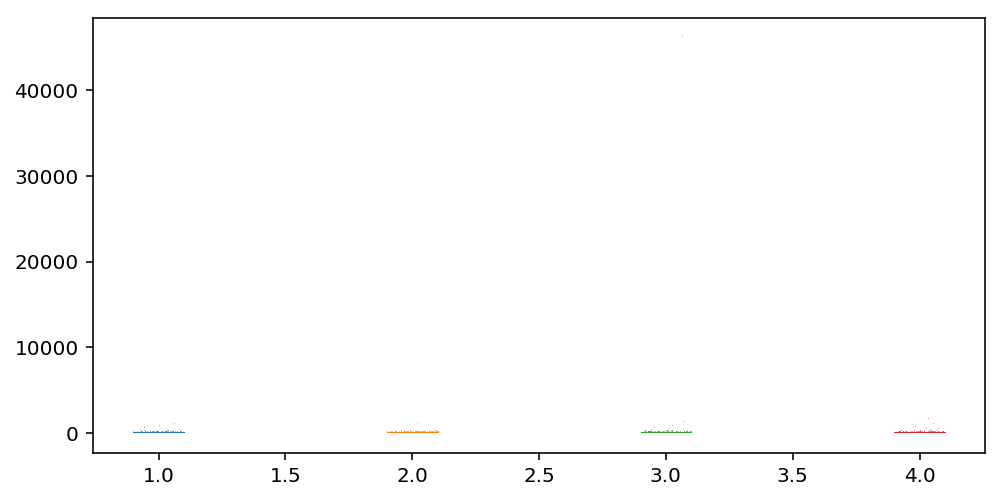

Alaska
[[ 3.10548793  3.12202624  0.92723628  0.43943682]
 [33.42930542 34.62447513  9.32616698  3.58062731]]


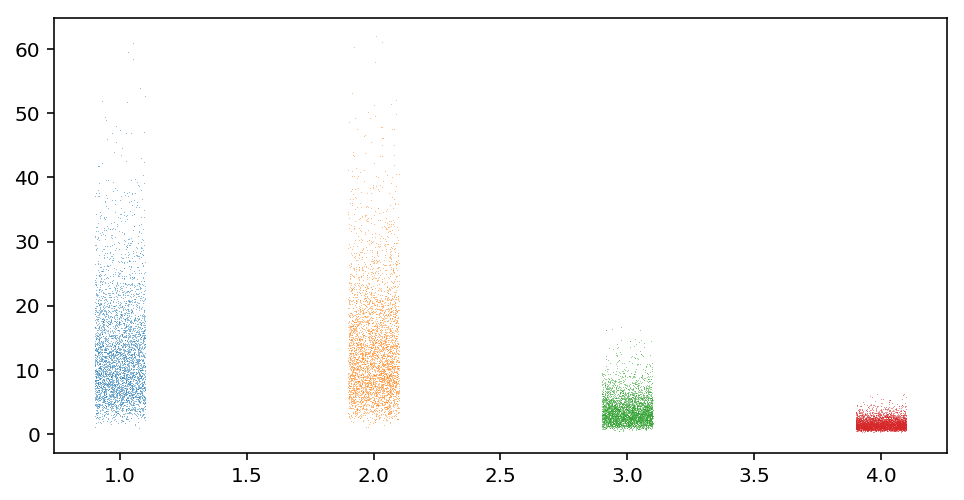

Arizona
[[ 50.39106351  52.55538256   6.82359663   2.02580226]
 [147.70204492 151.91946191  19.66981676   5.77918083]]


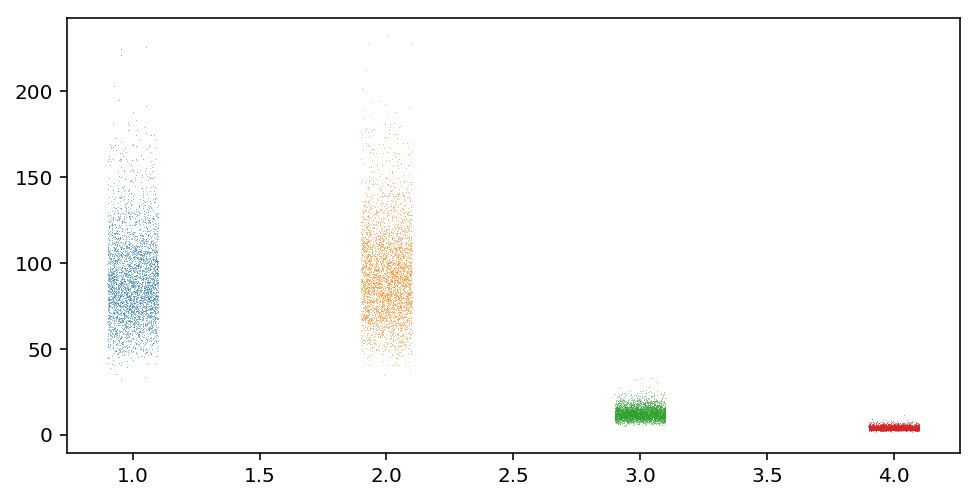

Arkansas
[[  2.45220469   4.2395178    0.4869164    0.30650104]
 [ 58.80188119 105.87326682   7.60008076   4.15766566]]


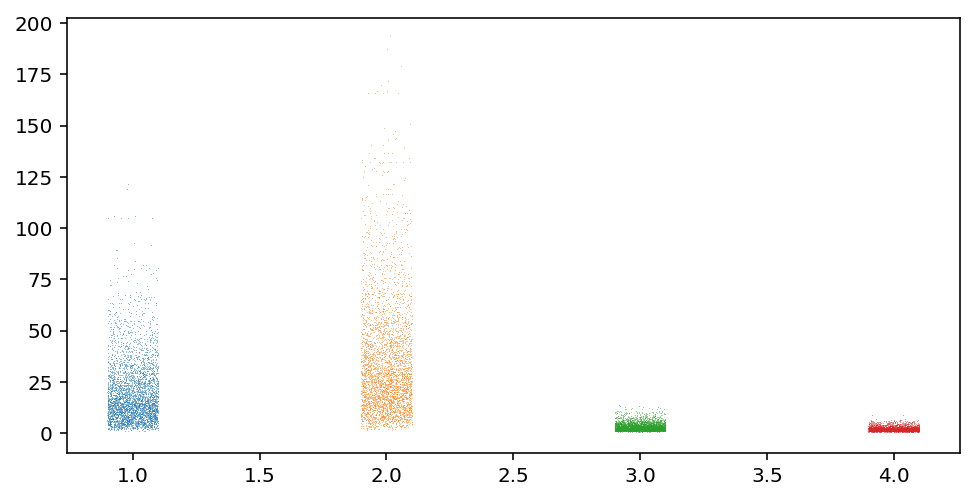

California
[[29.90629335 16.95966393  2.46565943  1.60196905]
 [87.9790919  50.36329738  7.55909009  4.9948848 ]]


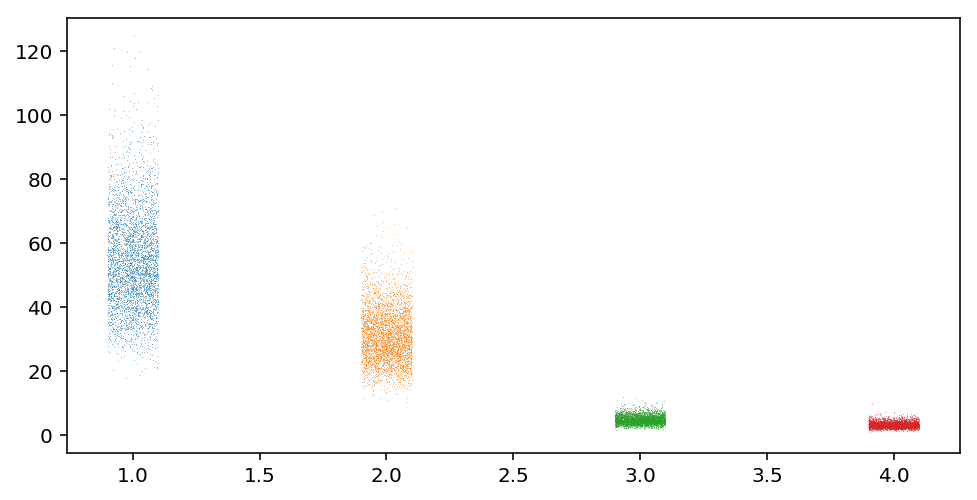

Colorado
[[ 47.74629078  43.60033719   8.76016101   3.0032582 ]
 [157.10927454 142.26817875  28.69859817   9.95641067]]


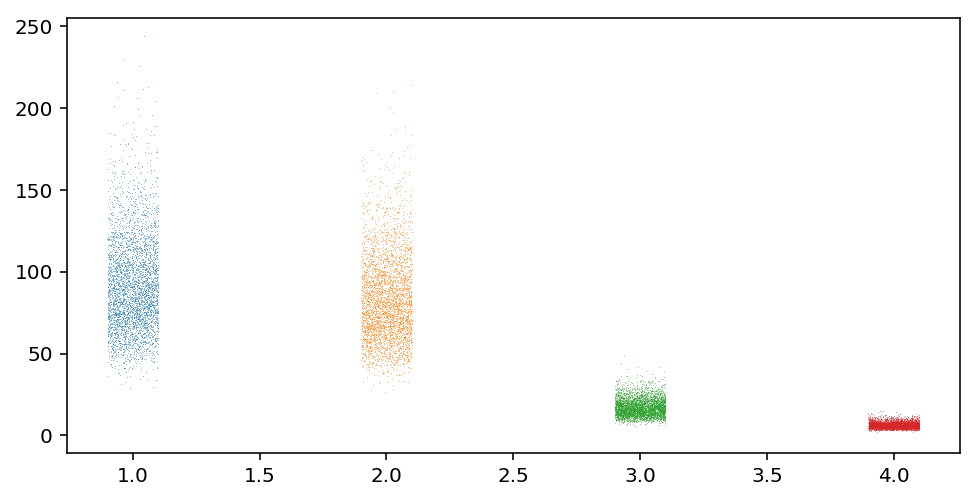

Connecticut
[[ 0.34419497  0.29425592  0.15268198  0.10445213]
 [15.53587969 10.59965719  3.46489126  2.25533507]]


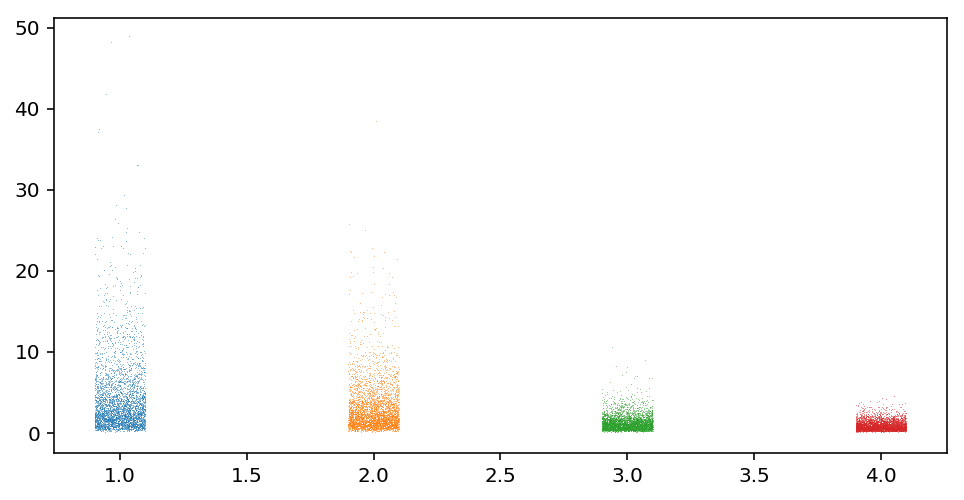

Delaware
[[ 0.38862862  0.23829939  0.1372021   0.0908951 ]
 [20.31224067 12.53013805  3.49168948  1.88999581]]


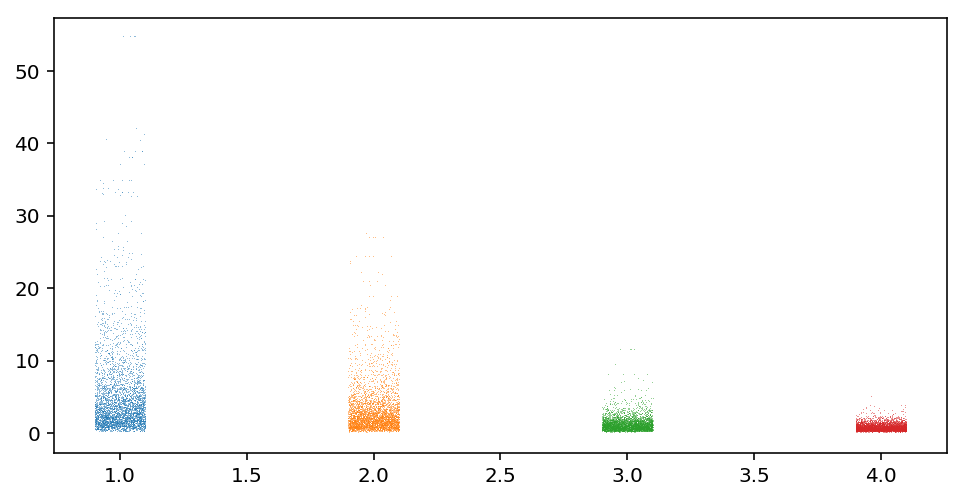

District of Columbia
[[ 0.03439804  0.04880327  0.05089208  0.03911099]
 [27.96774453 24.47594168 18.48308176 25.8289782 ]]


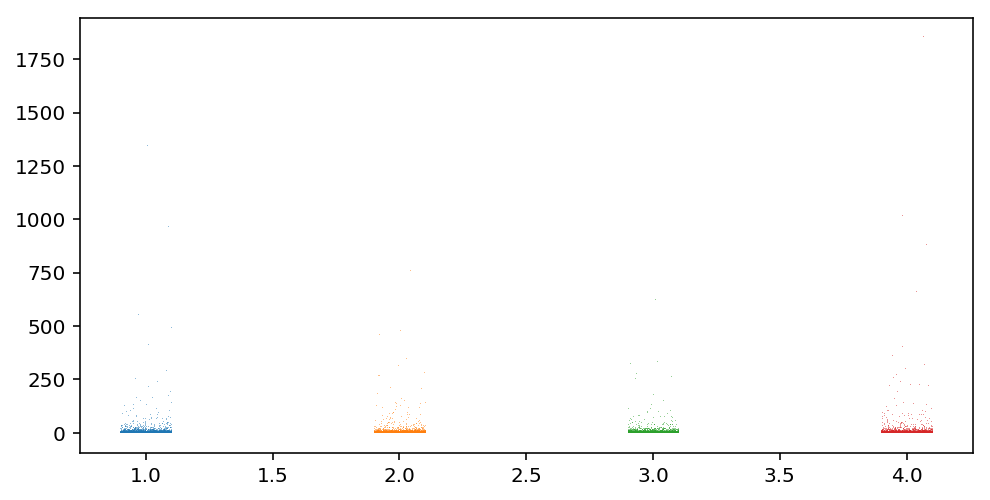

Florida
[[ 88.74644487  84.89227238   7.59598661   2.86178064]
 [182.77491642 175.20868662  15.9201867    6.04674418]]


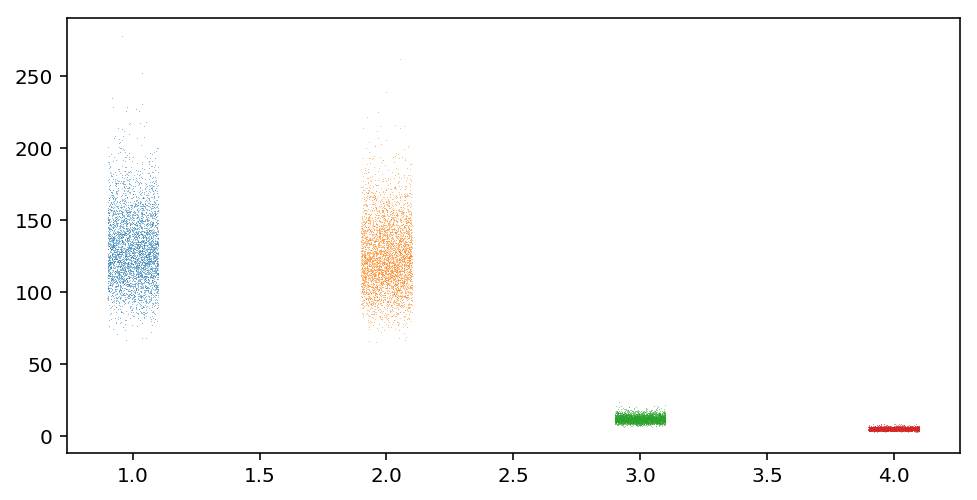

Georgia
[[ 1.35153149  1.69694462  0.26040851  0.10143358]
 [35.32996687 40.94321687  3.12847394  1.44762342]]


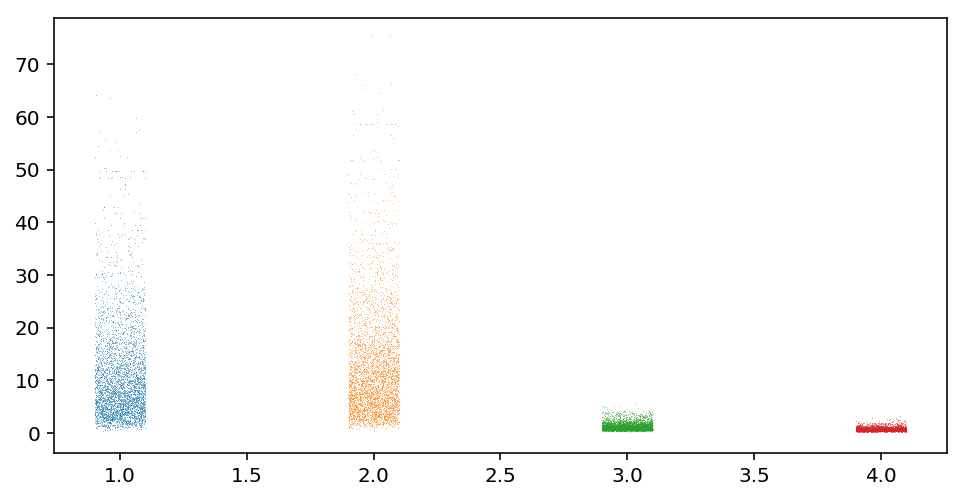

Hawaii
[[3.33772240e-02 3.88338845e-02 2.94692688e-02 3.73570558e-02]
 [3.08419117e+01 2.67973766e+01 2.51270427e+01 2.14049745e+01]]


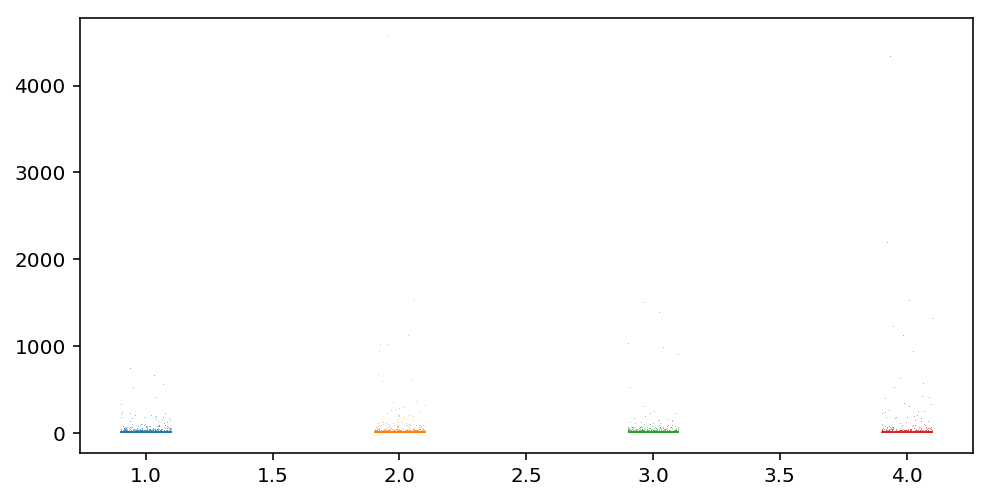

Idaho
[[ 0.28120176  0.3485428   0.15477595  0.1070524 ]
 [10.9999946  14.91226716  4.01890743  2.17953147]]


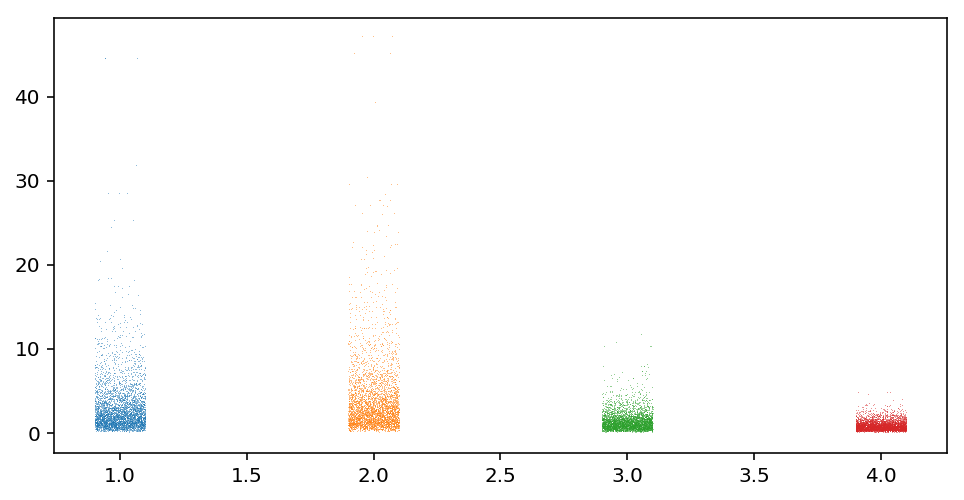

Illinois
[[ 24.79718794  17.36780038   2.63590439   0.82530289]
 [120.75715453  84.30193635  13.04906331   4.11878041]]


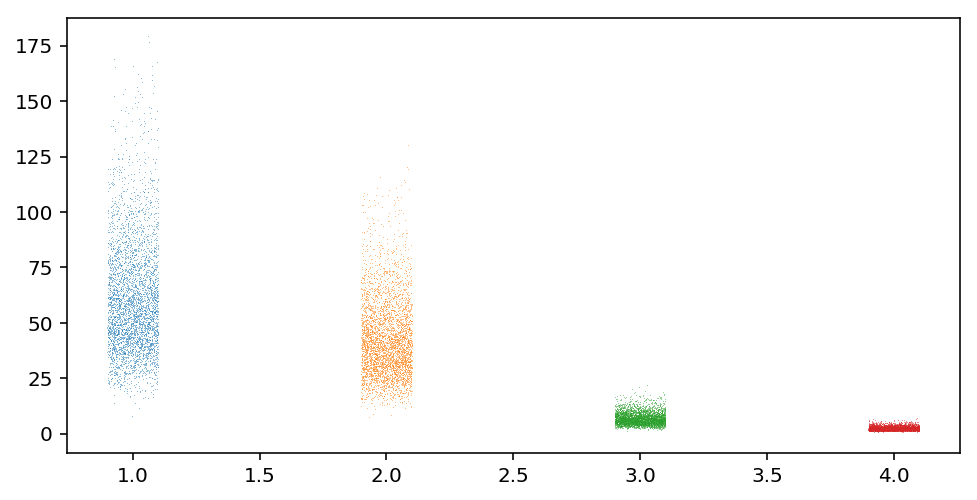

Indiana
[[ 0.31752372  0.31836486  0.14765087  0.08731617]
 [12.28624345 15.47630828  4.20955002  2.14135393]]


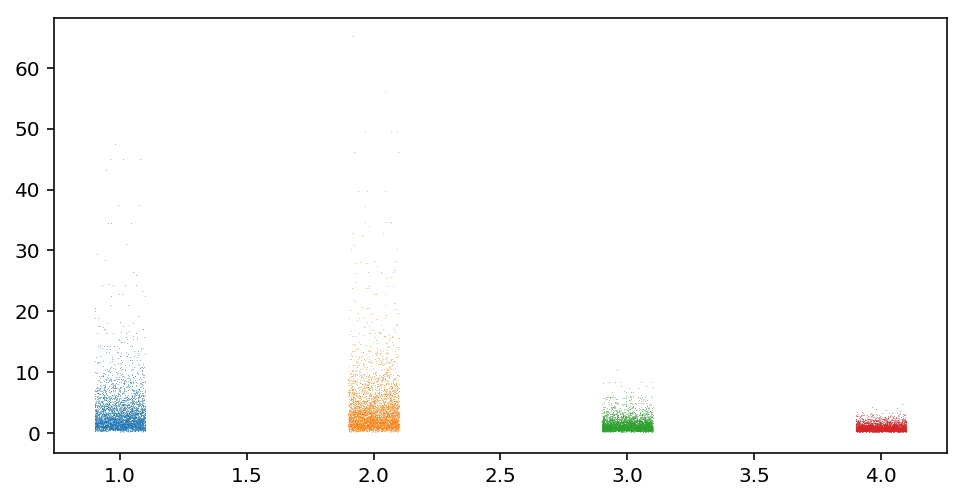

Iowa
[[ 26.35372327  28.31512786   4.0480096    1.35295412]
 [116.52326844 125.60113872  18.84850929   6.19774792]]


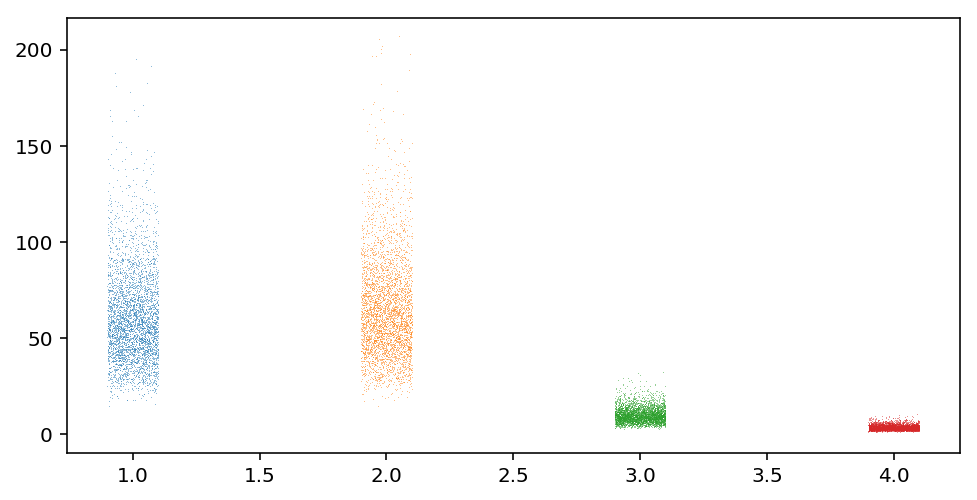

Kansas
[[  2.99192695   3.63307266   0.77089976   0.30974262]
 [ 90.87344064 116.73085527  16.68944309   4.56219175]]


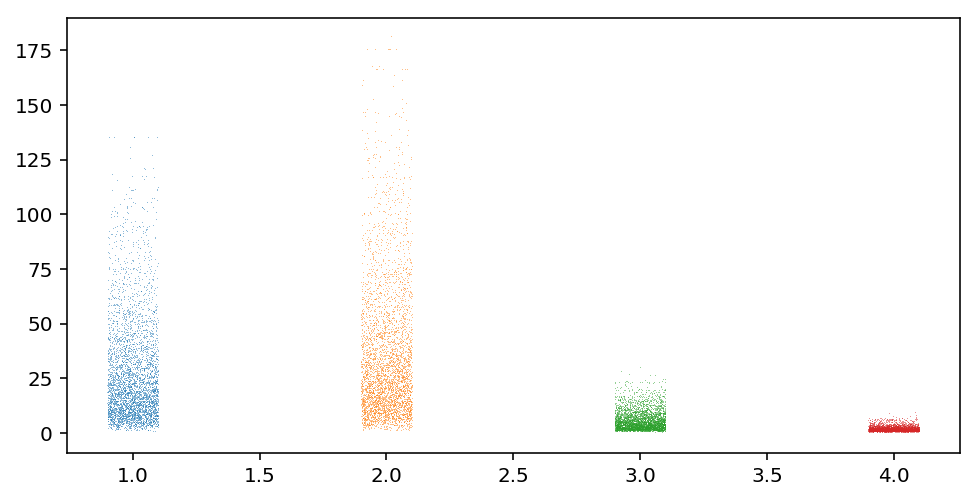

Kentucky
[[  1.08013633   1.63954243   0.15749558   0.15636115]
 [ 86.63375834 125.08161465   2.82294989   3.03430919]]


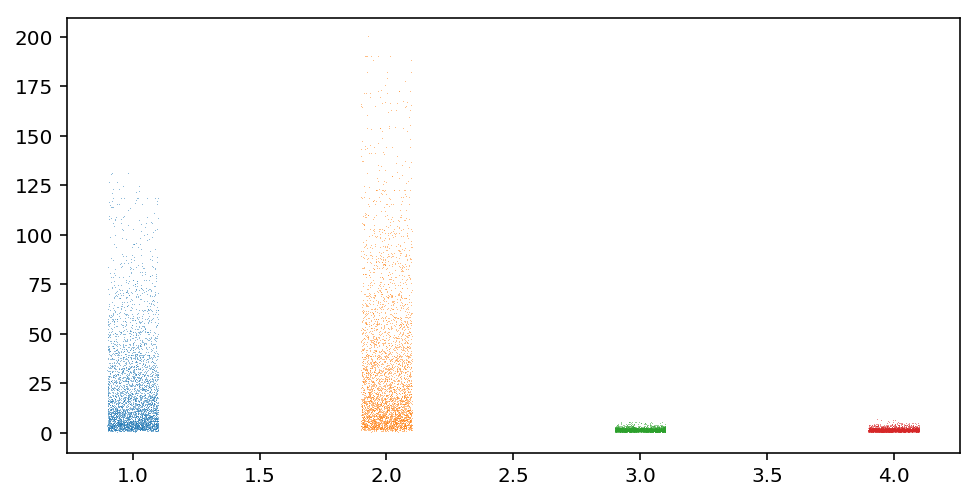

Louisiana
[[ 5.32096913  7.18563603  0.74474041  0.37964781]
 [72.53442757 95.45513613  9.56462406  3.46310168]]


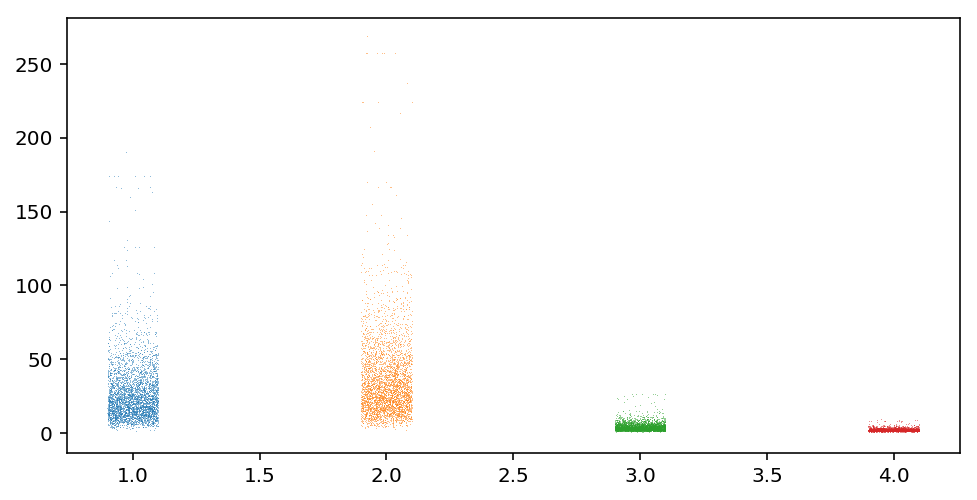

Maine
[[ 39.89145461  34.68981657   8.51910765   3.20202037]
 [205.86007761 176.79399428  44.47048394  16.43029756]]


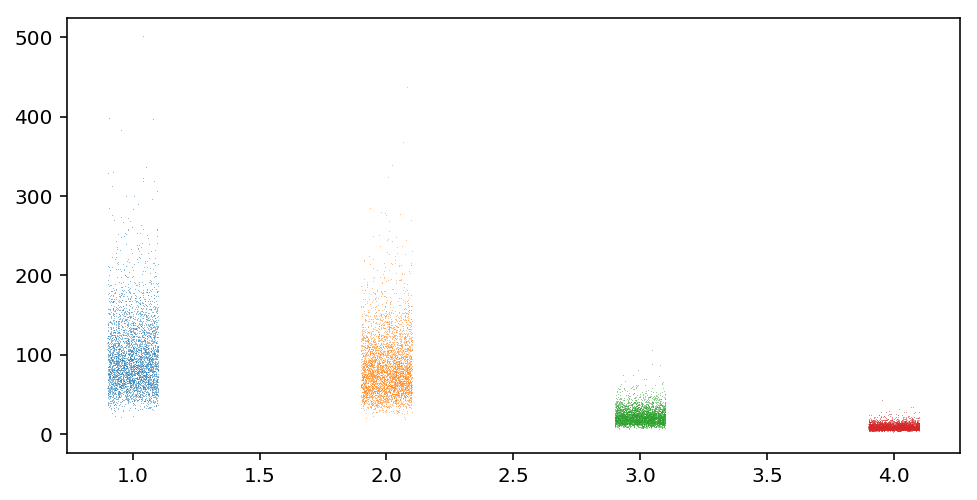

Maryland
[[ 1.69233523  0.80687204  0.27200187  0.17575872]
 [74.40149071 32.60658015  6.57404655  2.94219961]]


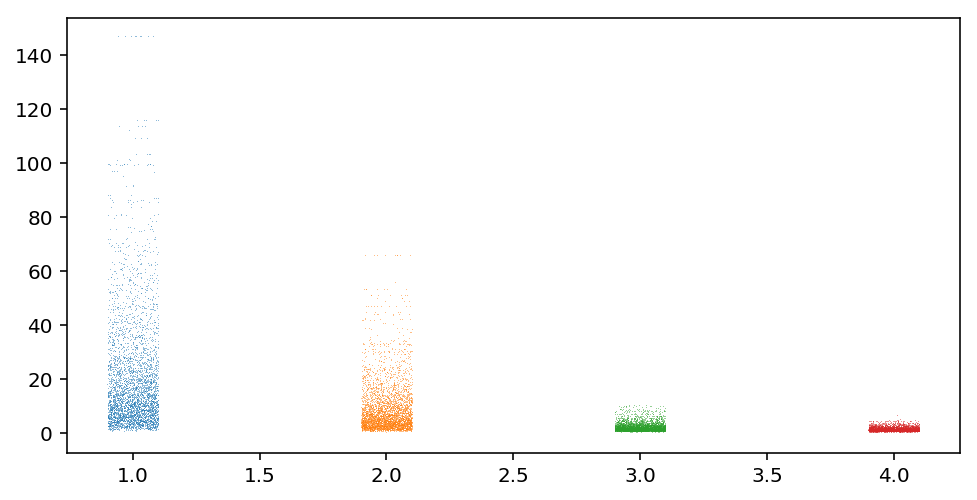

Massachusetts
[[ 25.94425887  13.2866524    3.59175162   1.52274129]
 [181.28053919  96.69100679  25.92510227  11.0803879 ]]


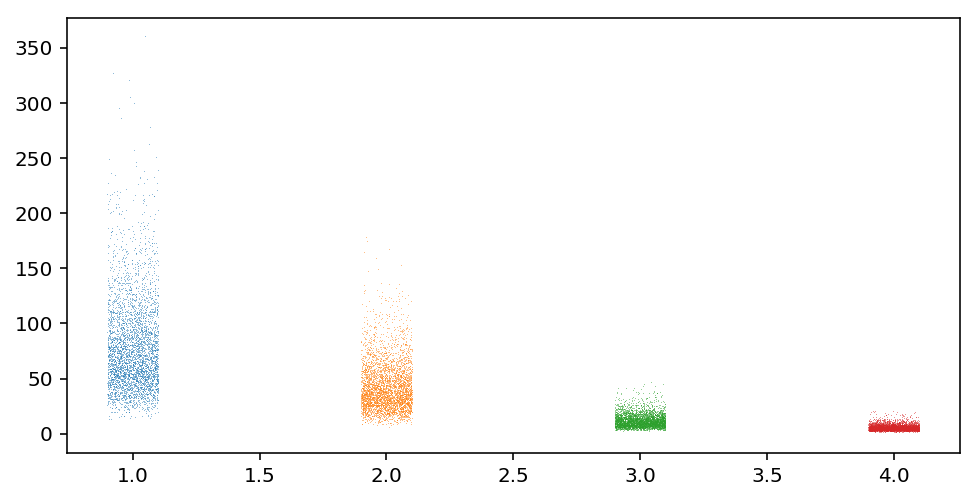

Michigan
[[42.25812182 36.51139516  5.77994413  2.29109533]
 [96.22115395 83.38507399 13.43828639  5.24547708]]


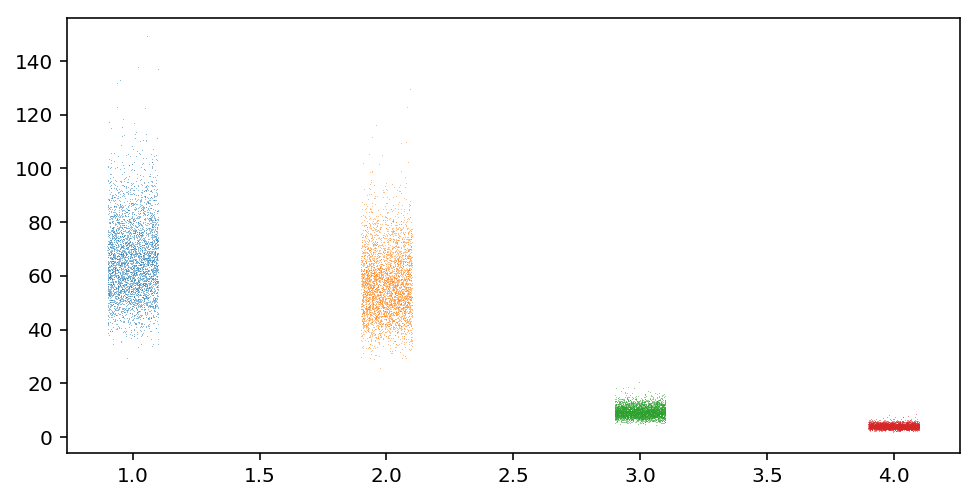

Minnesota
[[ 10.86998254   9.05624447   1.34800331   0.57449757]
 [197.16401614 160.16923241  24.67858891   7.86969461]]


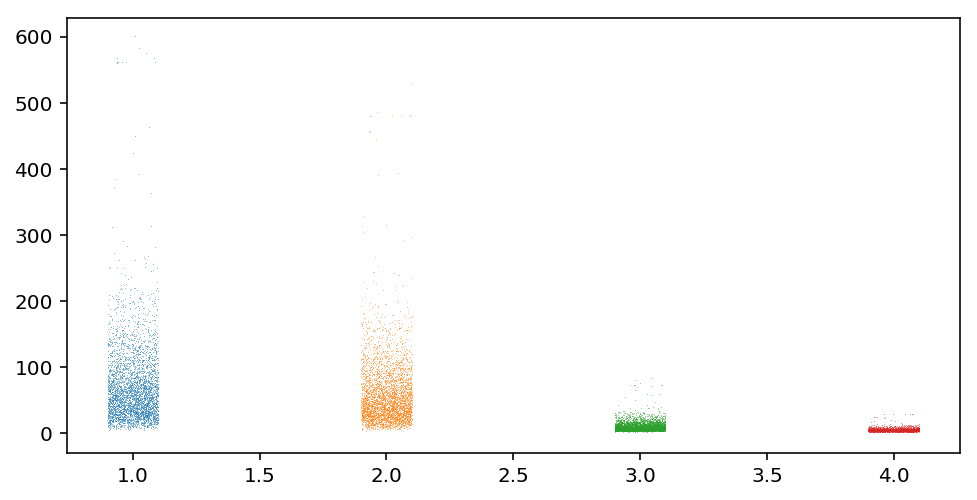

Mississippi
[[2.86761849e-02 2.85010248e-02 4.25463384e-02 4.15856934e-02]
 [2.55201929e+01 2.86944497e+01 3.04834497e+01 2.97014050e+01]]


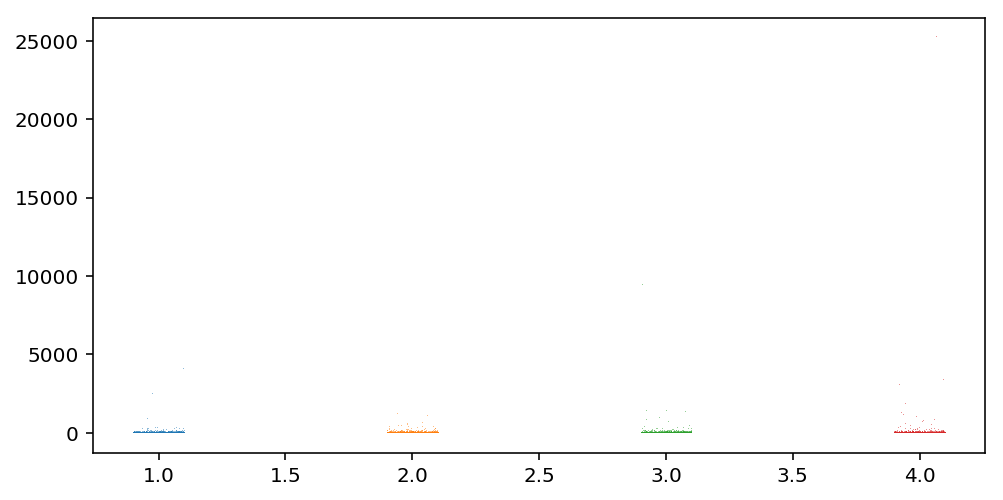

Missouri
[[ 48.1137951   59.67727729   5.75446307   2.29818543]
 [164.12837641 205.57767041  20.40662185   8.16423509]]


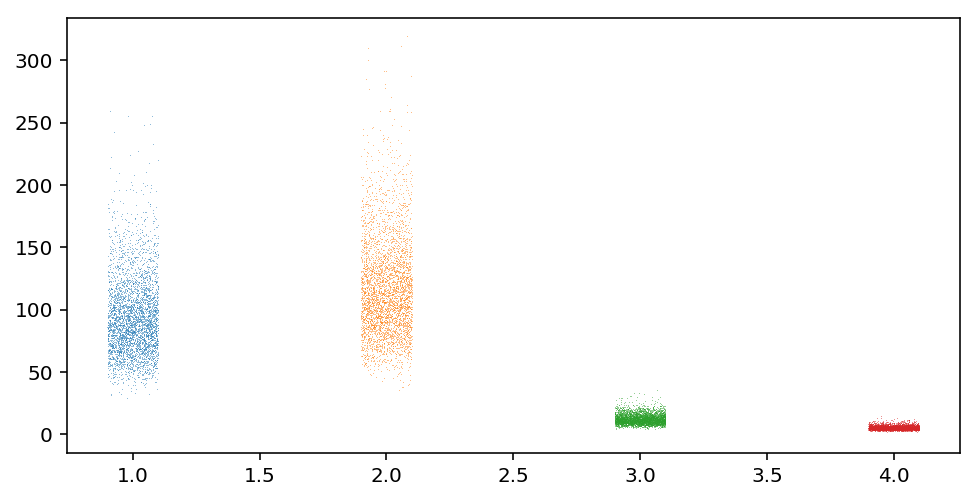

Montana
[[ 0.25500278  0.3919472   0.16323491  0.09277471]
 [10.8193906  17.74941479  3.6198552   1.91902772]]


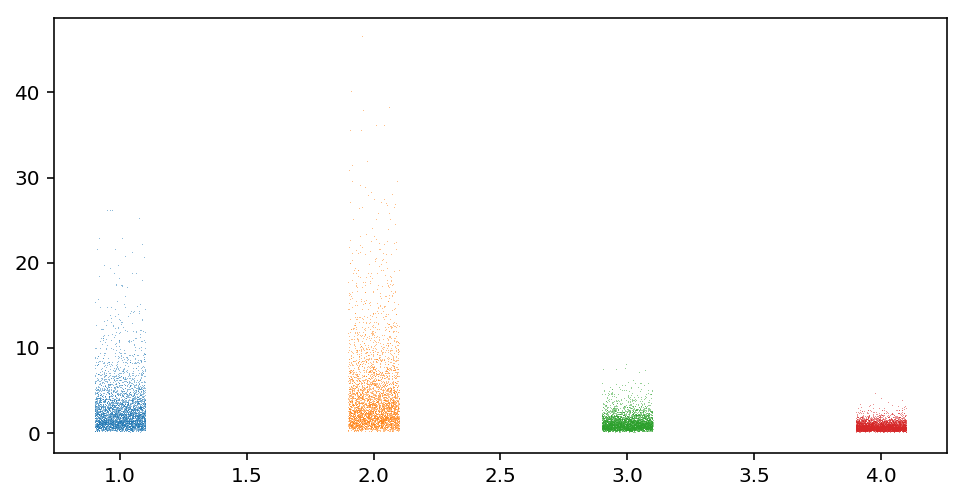

Nebraska
[[ 0.25723839  0.42342853  0.11854016  0.07927285]
 [12.2521683  23.82475496  3.31262446  1.50754133]]


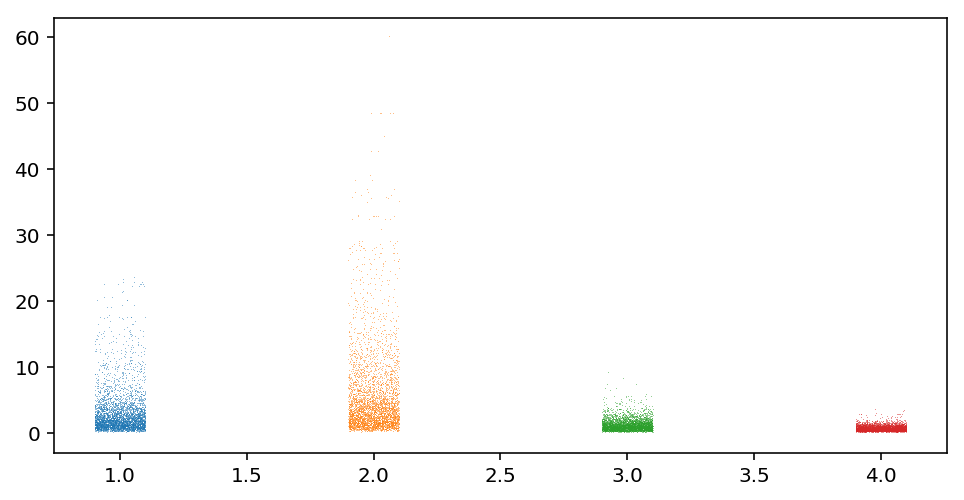

Nevada
[[16.19043111 16.13896233  1.92456701  0.63005617]
 [79.45224388 79.34087464  9.63079173  3.36350966]]


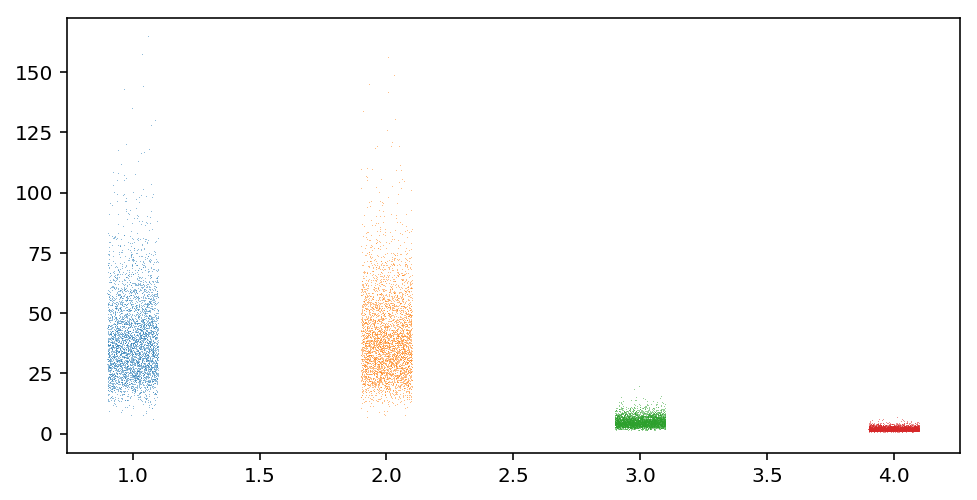

New Hampshire
[[36.49087346 32.64485798  6.54798722  1.97859289]
 [87.05532186 78.23893446 15.92423798  5.00194018]]


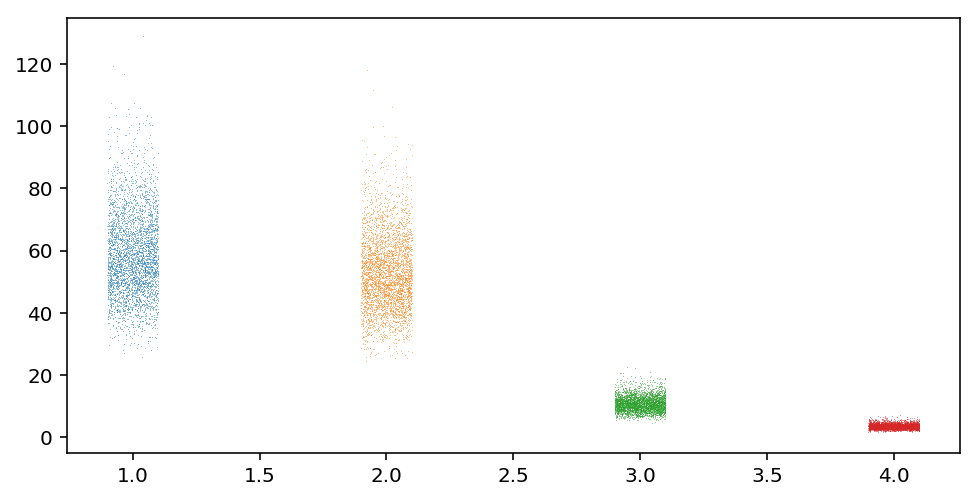

New Jersey
[[ 5.92488425  4.20202154  0.70707125  0.44874534]
 [66.8199622  50.50339802  6.92739408  3.77439632]]


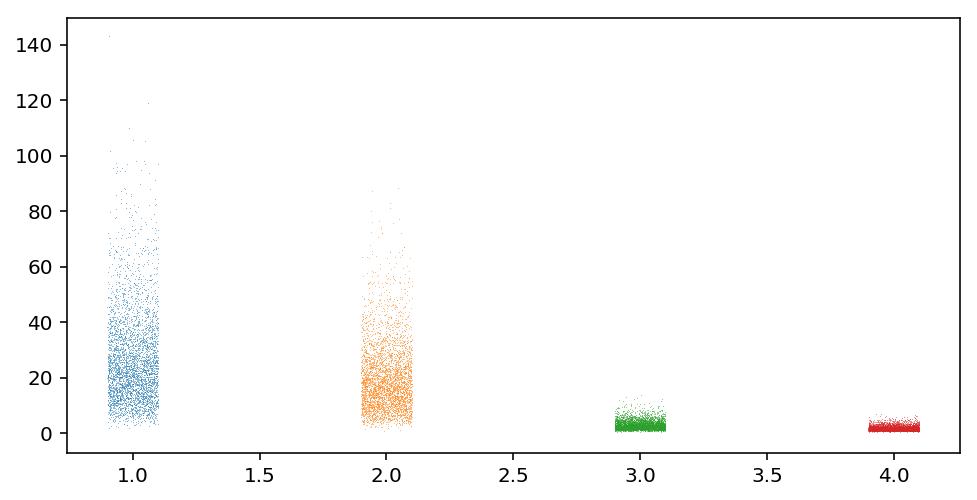

New Mexico
[[ 9.33994641  8.01824719  2.39856557  0.56891961]
 [50.51312841 43.7351286  12.55536519  2.6699106 ]]


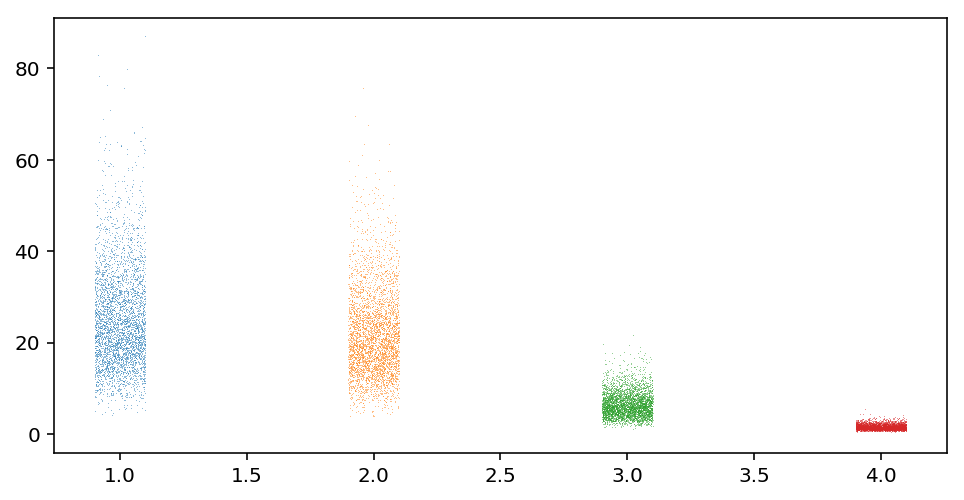

New York
[[  7.64803596   4.63312274   0.98476678   0.66527395]
 [135.50854364  81.24370689  16.39783708   8.97899899]]


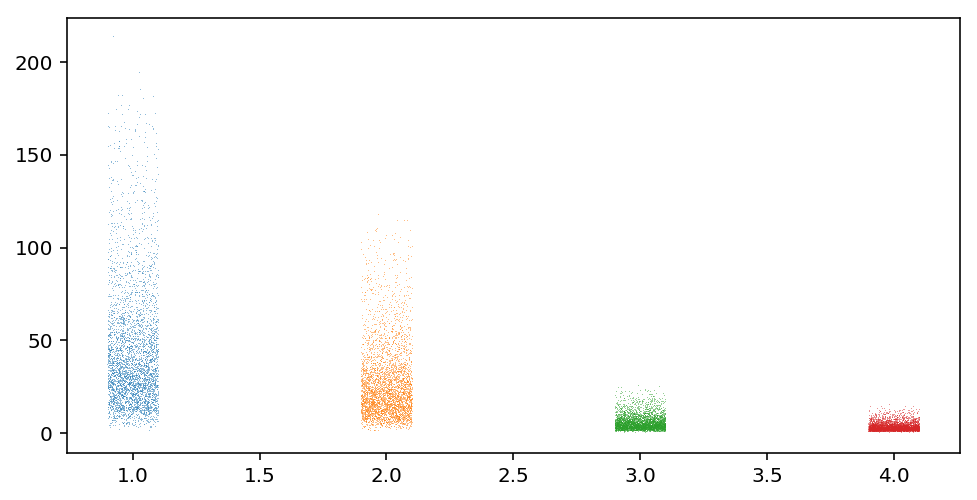

North Carolina
[[13.84606967 13.10117768  1.72537026  0.19121419]
 [64.43367704 62.66007912  8.0386151   1.15975468]]


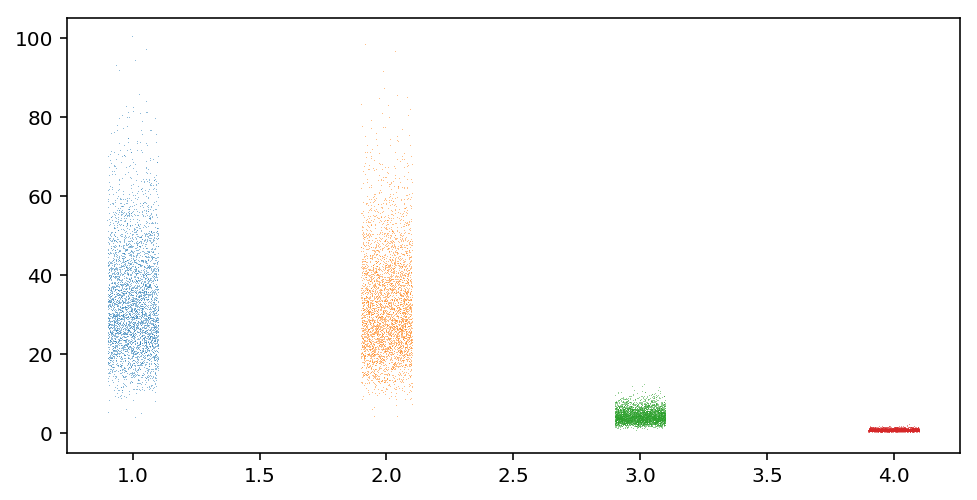

North Dakota
[[ 0.28101806  0.32910474  0.13643115  0.06904739]
 [12.70902506 17.11155606  3.54074026  1.622151  ]]


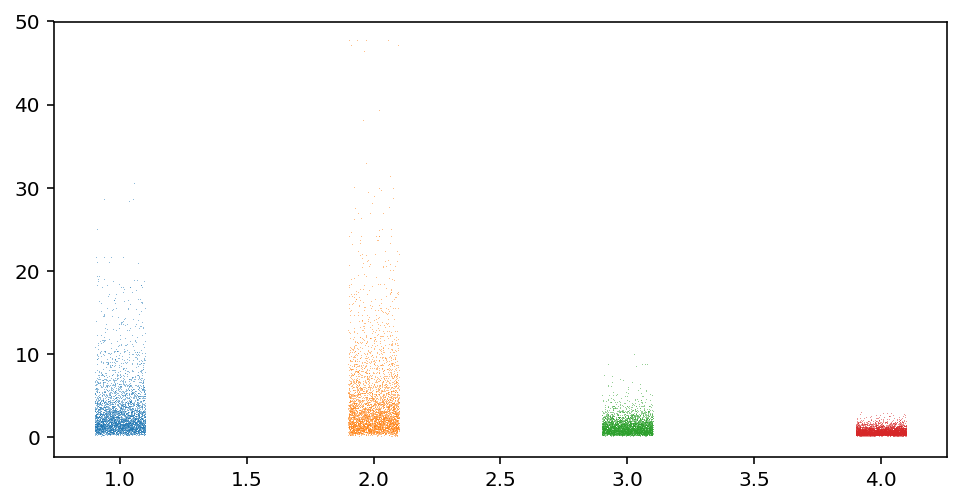

Ohio
[[ 51.85913525  52.45096977   7.3780255    2.40324933]
 [120.53332435 122.54650451  17.56882181   5.700584  ]]


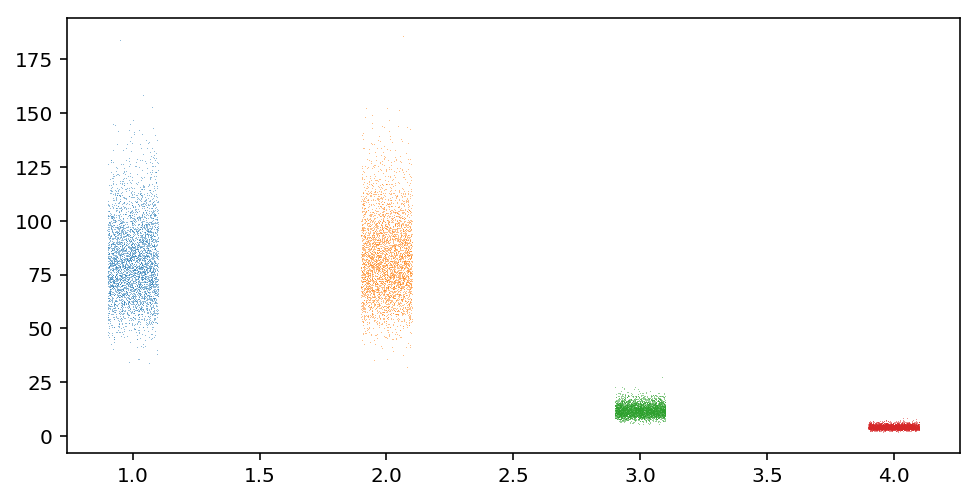

Oklahoma
[[ 0.03837631  0.03347575  0.04423259  0.03865492]
 [21.99552858 28.56980961 23.94571715 26.54613939]]


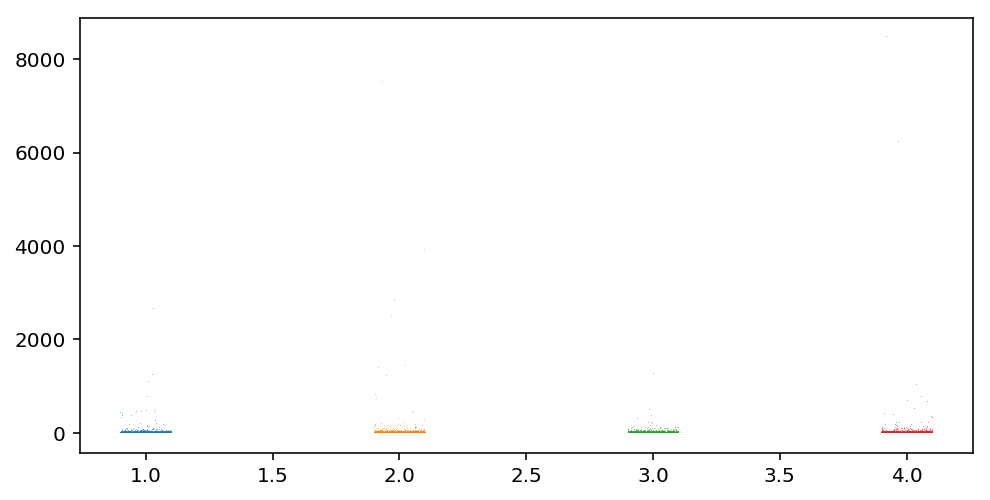

Oregon
[[ 16.70275253  12.72309435   2.77911864   1.40445826]
 [120.47428094  90.41038343  19.71998425   9.99006057]]


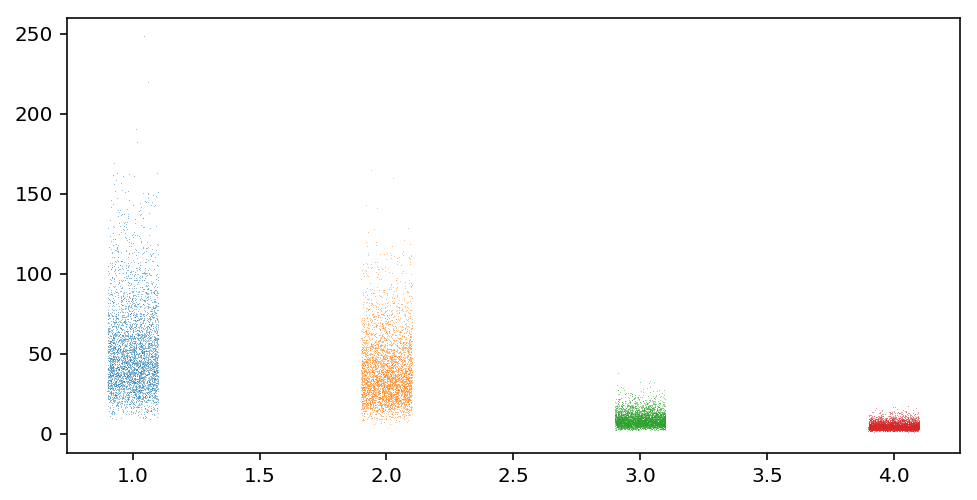

Pennsylvania
[[ 57.89590829  51.5968993    6.40520757   2.65739061]
 [130.94330586 115.25810264  14.854893     6.27137037]]


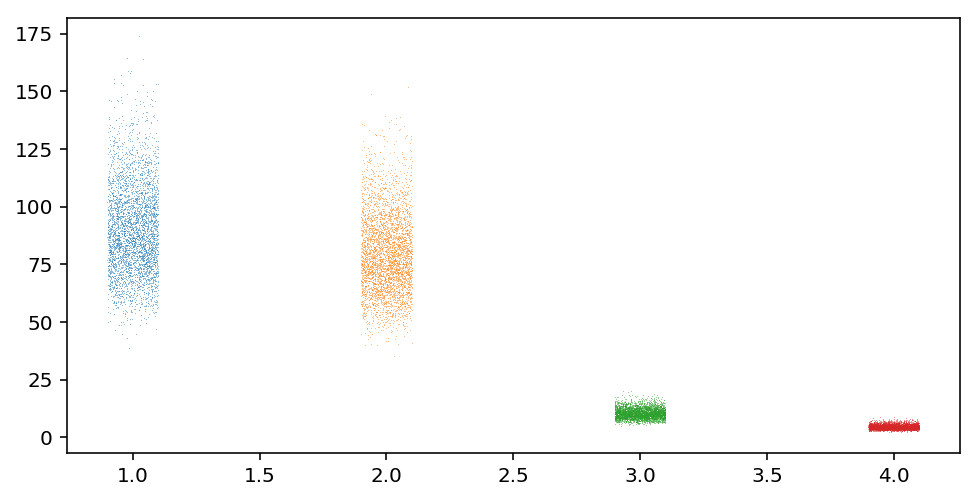

Rhode Island
[[ 0.95403537  0.73293232  0.24999993  0.22133385]
 [31.42502138 23.86544364  4.12203162  3.57981769]]


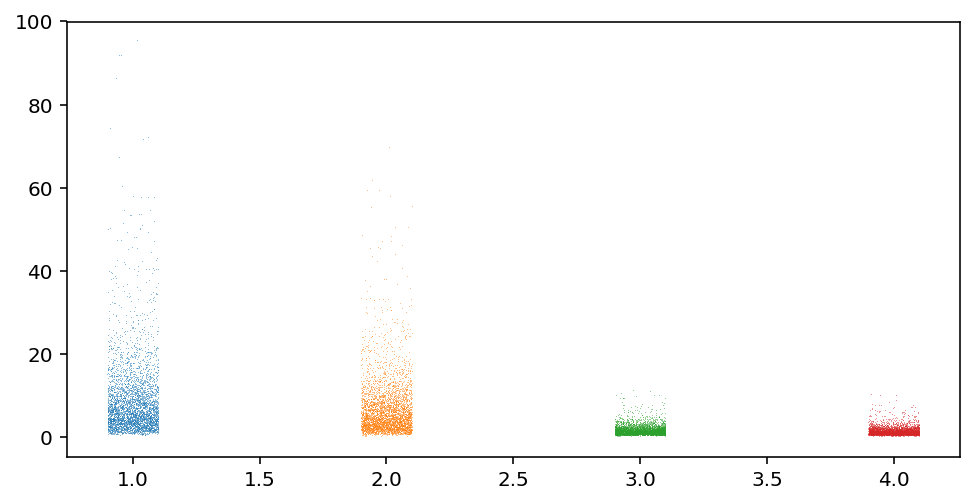

South Carolina
[[ 0.88160857  0.99011917  0.22981148  0.14971343]
 [33.67977916 41.46615917  4.25330177  2.21499355]]


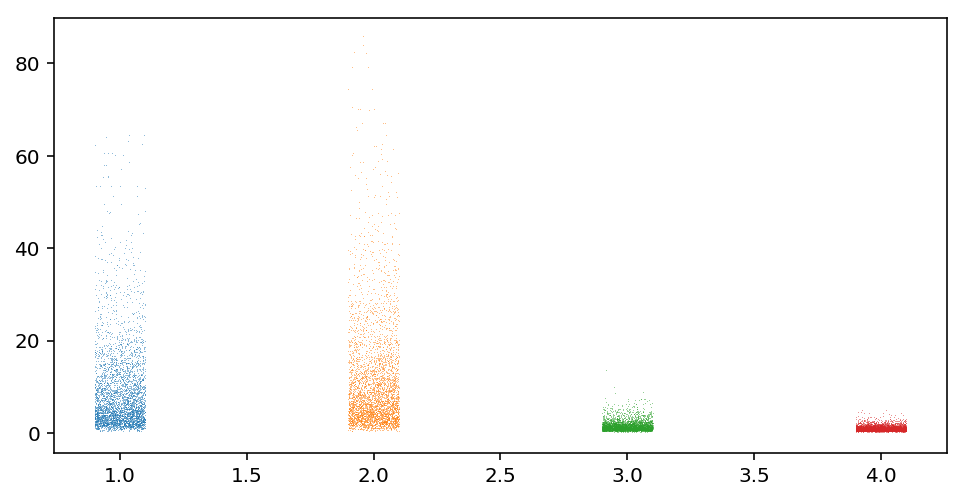

South Dakota
[[ 0.0411778   0.04354467  0.03924218  0.04338875]
 [24.37677013 26.46748053 22.45402144 25.2423731 ]]


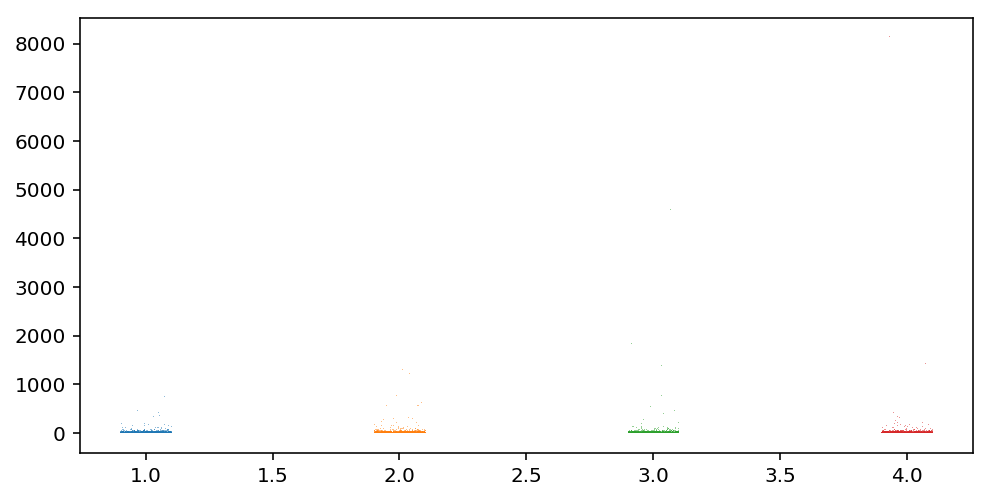

Tennessee
[[  2.67734837   3.47843432   0.63219296   0.25213915]
 [ 82.54774032 106.64308445  14.35814674   3.03634082]]


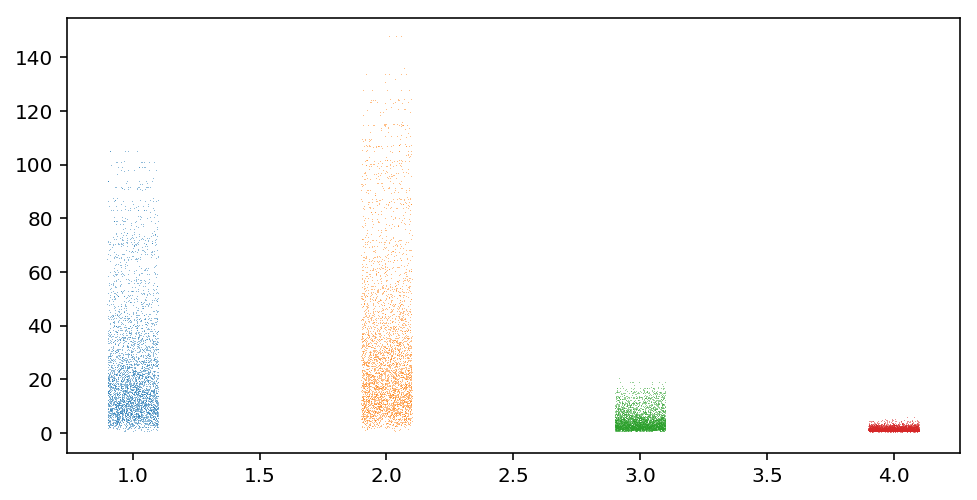

Texas
[[14.48027794 17.10111899  2.04035308  0.67108202]
 [56.70292693 66.62259285  8.22060259  2.76232168]]


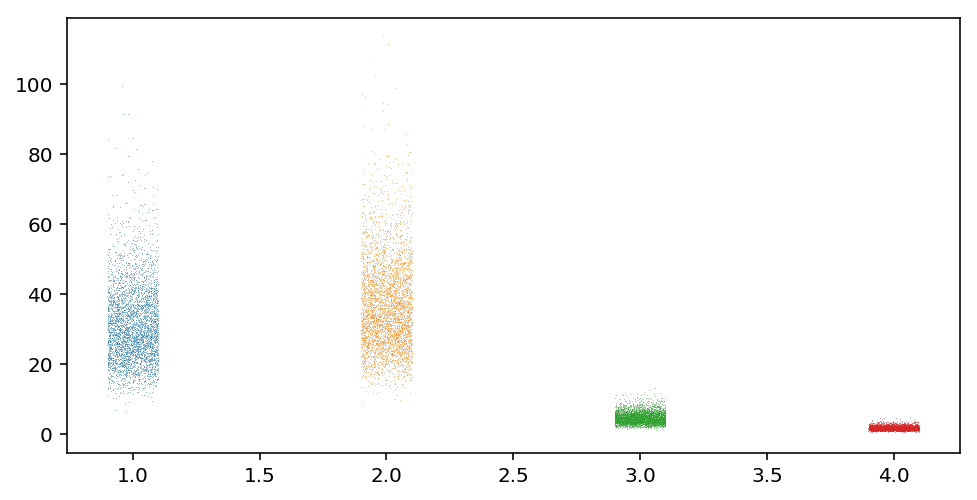

Utah
[[10.65990951 13.96827189  2.71319069  0.51739653]
 [36.54717566 48.52728963  9.33997386  1.84520773]]


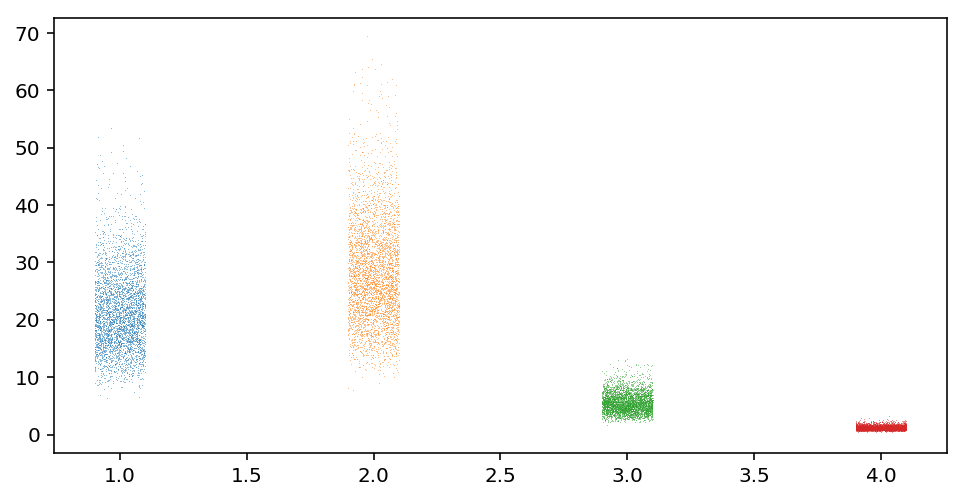

Vermont
[[ 4.64358978  2.09975647  0.7449824   0.52629867]
 [55.21660282 26.40077201  8.08378523  4.79591067]]


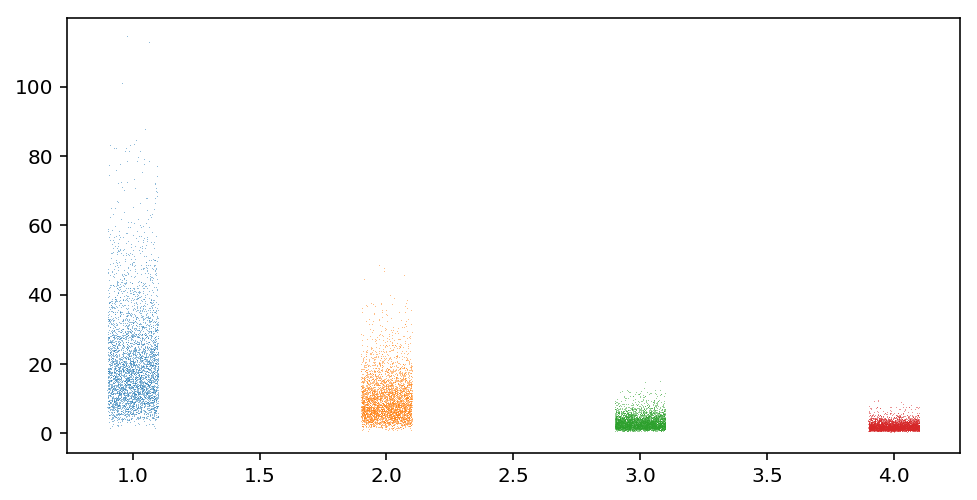

Virginia
[[ 40.21254221  33.78424951   5.53653877   1.30870293]
 [102.31292731  85.55093578  14.6647815    3.46537143]]


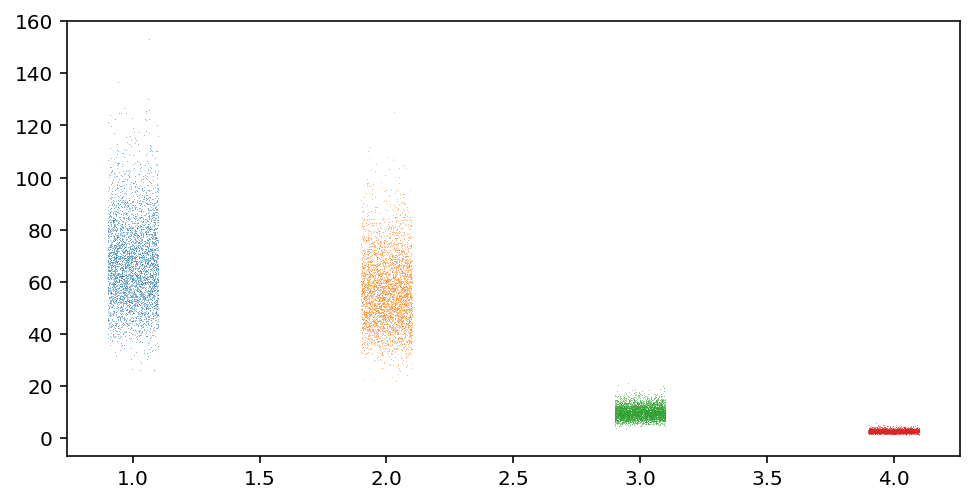

Washington
[[ 4.00000967  2.93390033  0.61159174  0.4058781 ]
 [30.38675572 21.83291238  4.33234553  2.62099678]]


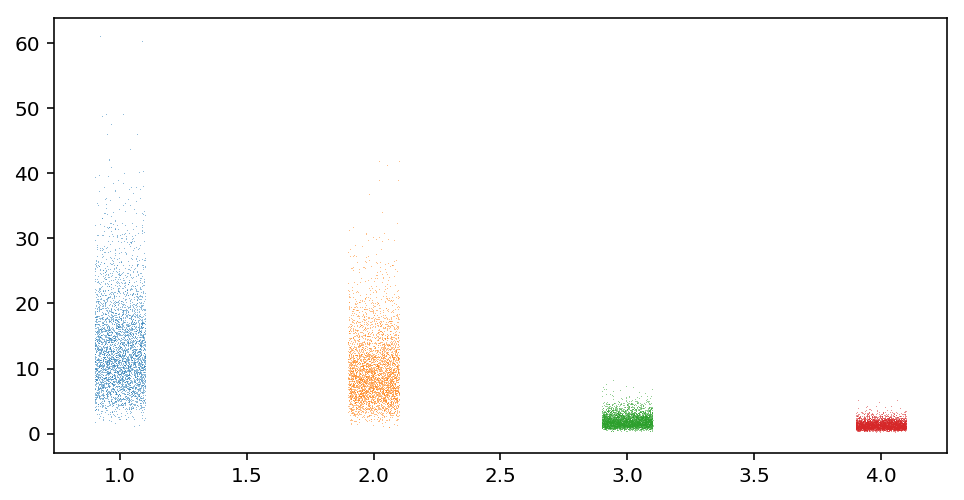

West Virginia
[[ 0.03910307  0.04063192  0.0420932   0.0448213 ]
 [26.32215943 23.59373411 30.4349445  25.07523925]]


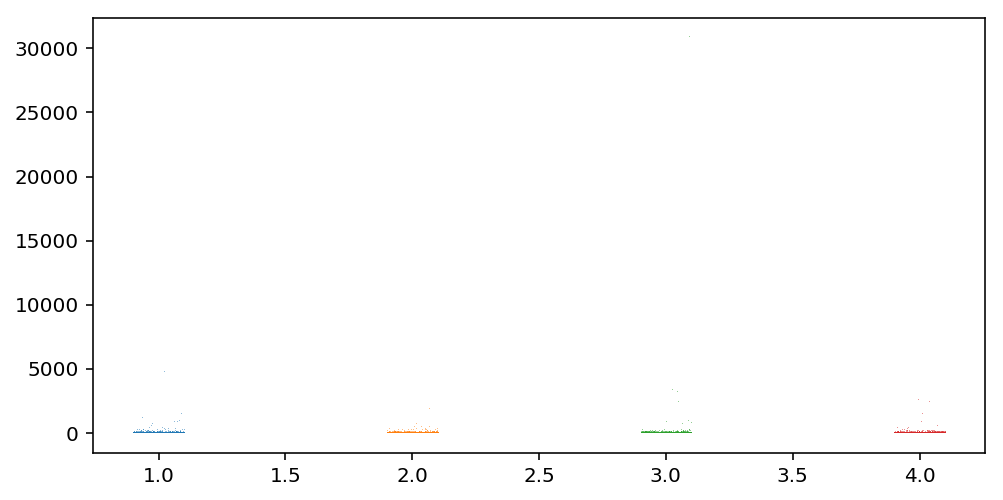

Wisconsin
[[21.34014385 18.39143202  2.76026725  0.99774683]
 [81.41364936 70.80999821 11.38779929  3.83809867]]


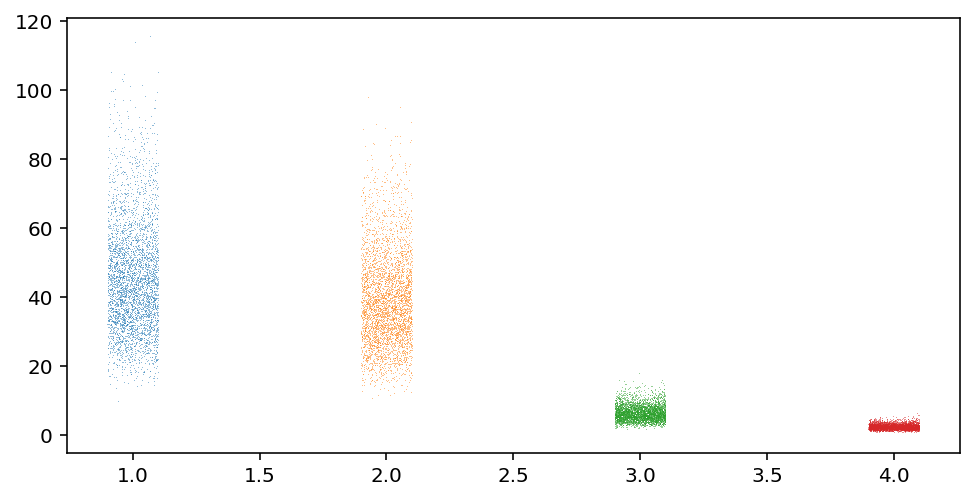

Wyoming
[[ 0.63235744  1.44425988  0.39914548  0.17885491]
 [19.63837172 57.77276281  9.09442853  2.54228644]]


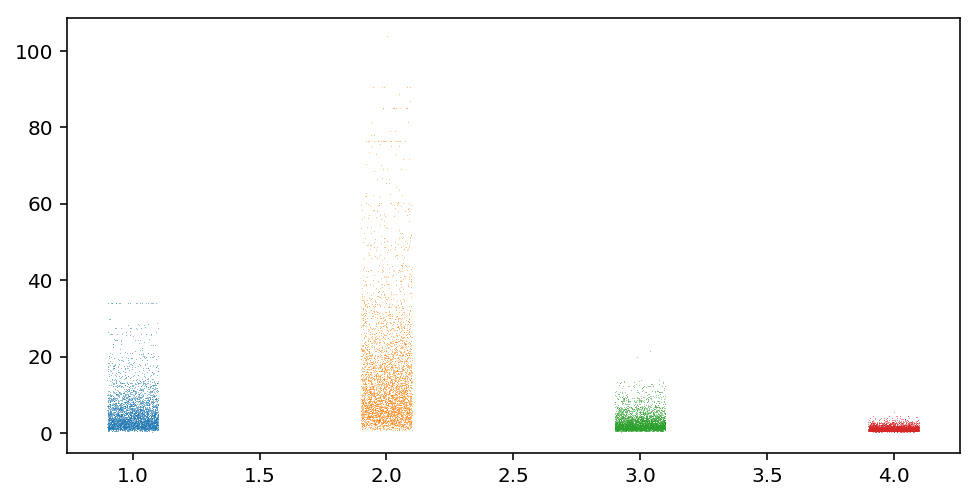

In [4]:
# Sample results for all states

print('Posterior α samples and 95% confidence intervals for each state\n')

results = {}
for state in states:
    data = {
        'S': survey_results[state].shape[0],
        'C': 4,
        'survey_results': survey_results[state],
        'cauchy_location': 0,
        'cauchy_scale': 1}
    results[state] = stan_model.sampling(data=data)
    samples = results[state].extract()

    print(state)
    print(np.percentile(samples['alpha'], [2.5, 97.5], axis=0))
    plt.figure(figsize=(8,4))
    for i in range(4):
        plt.plot(stats.uniform.rvs(loc=i+1-0.1, scale=0.2, size=4000), samples['alpha'][:,i], ',', alpha=0.5)
    plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ — the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

/ext/anaconda5/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


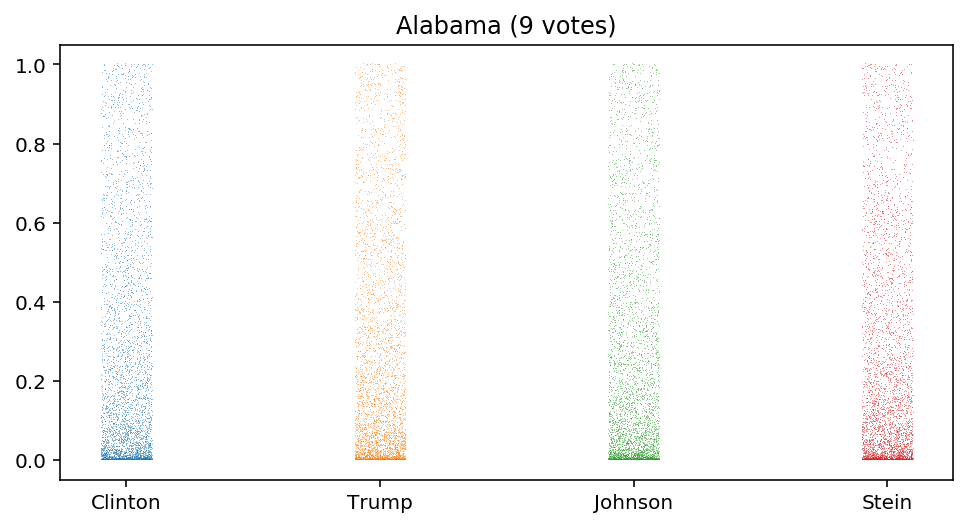

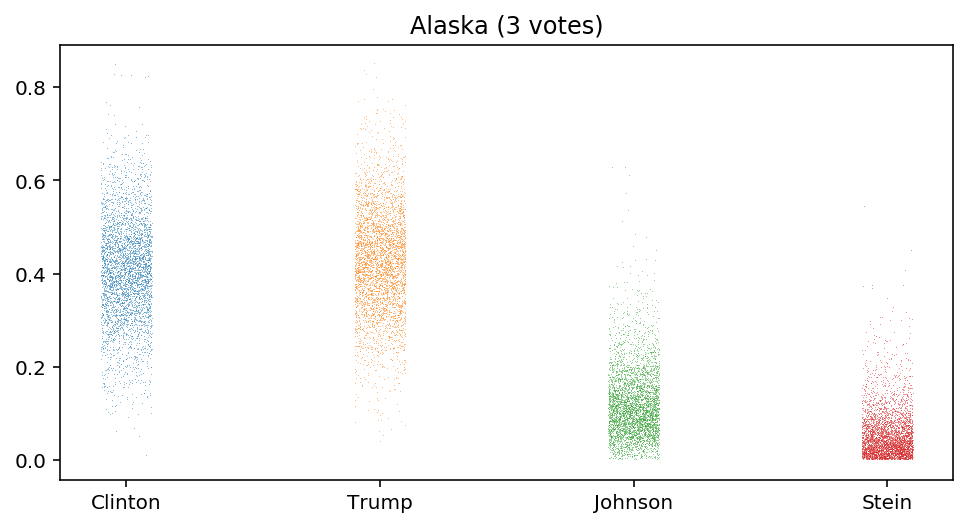

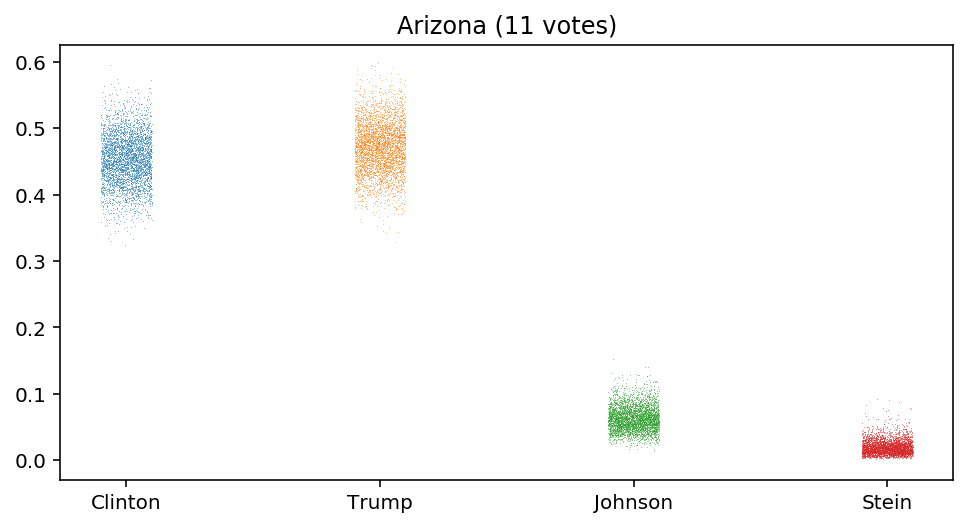

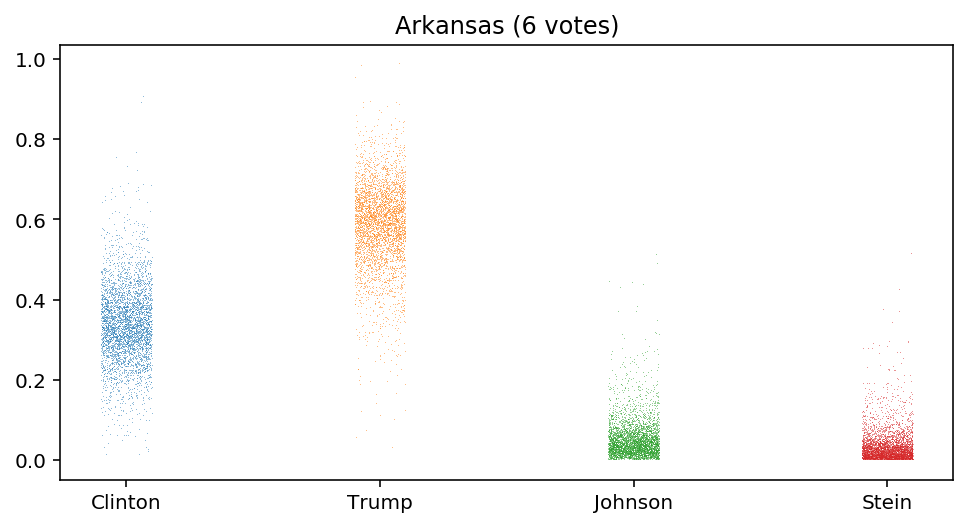

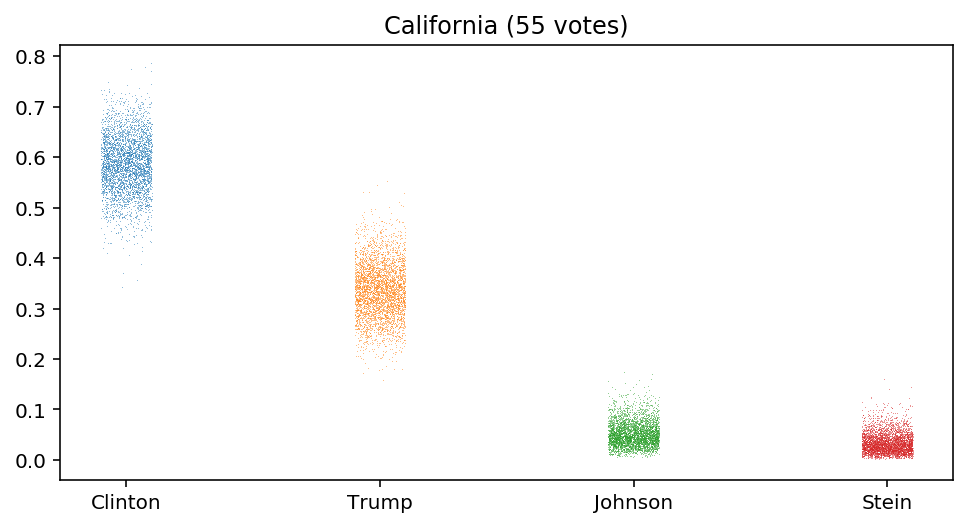

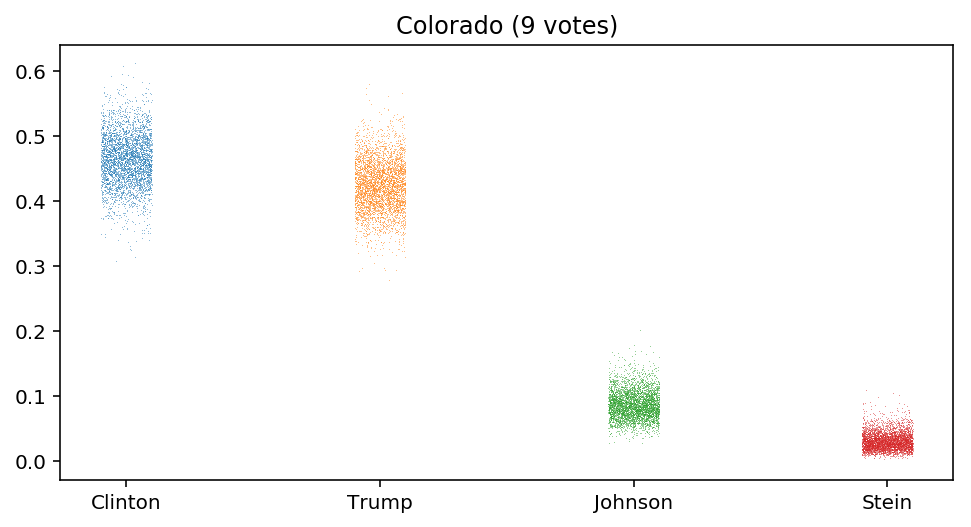

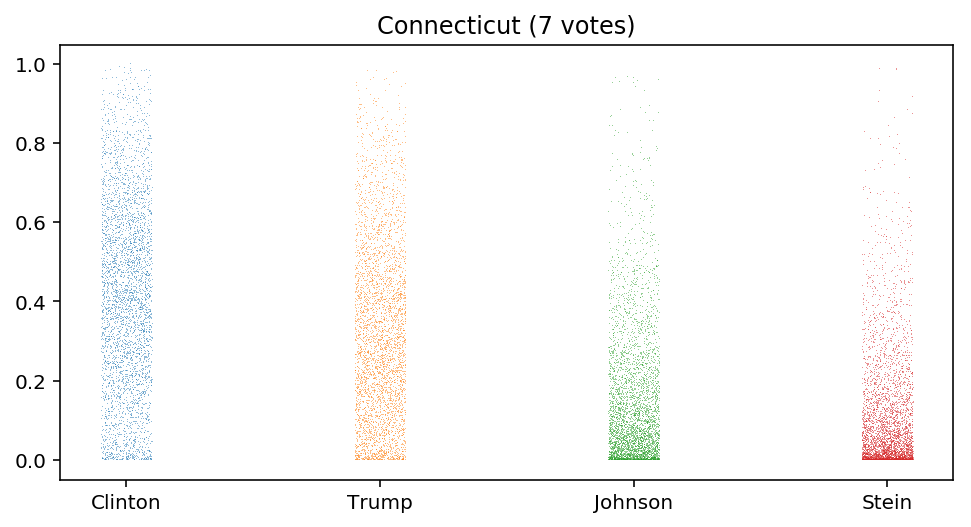

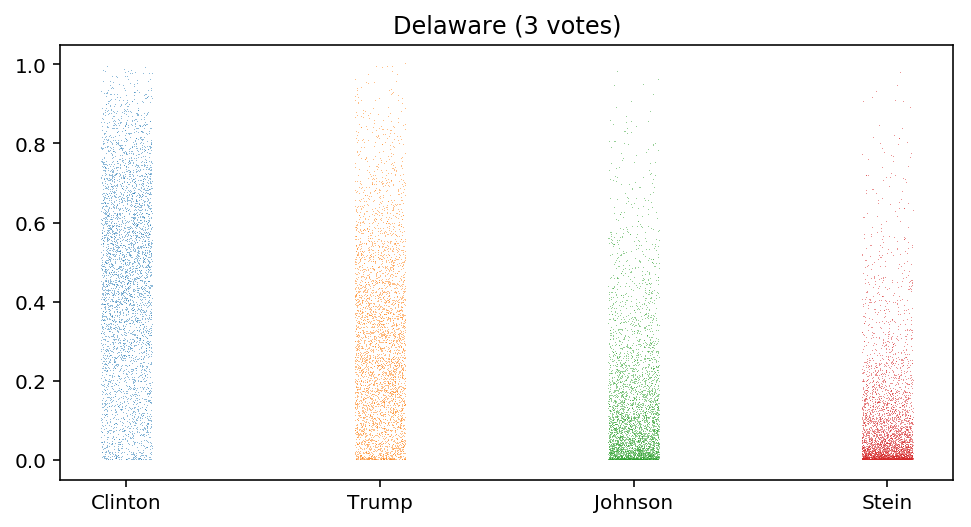

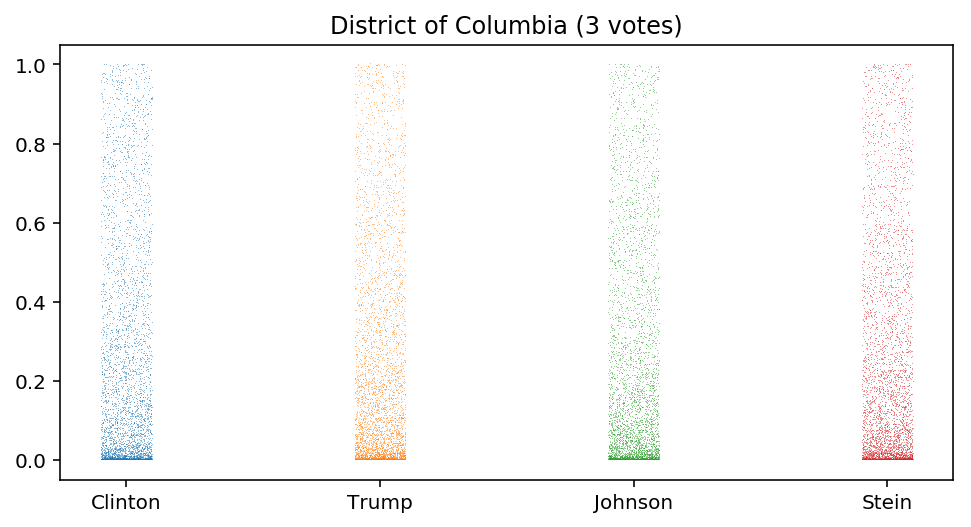

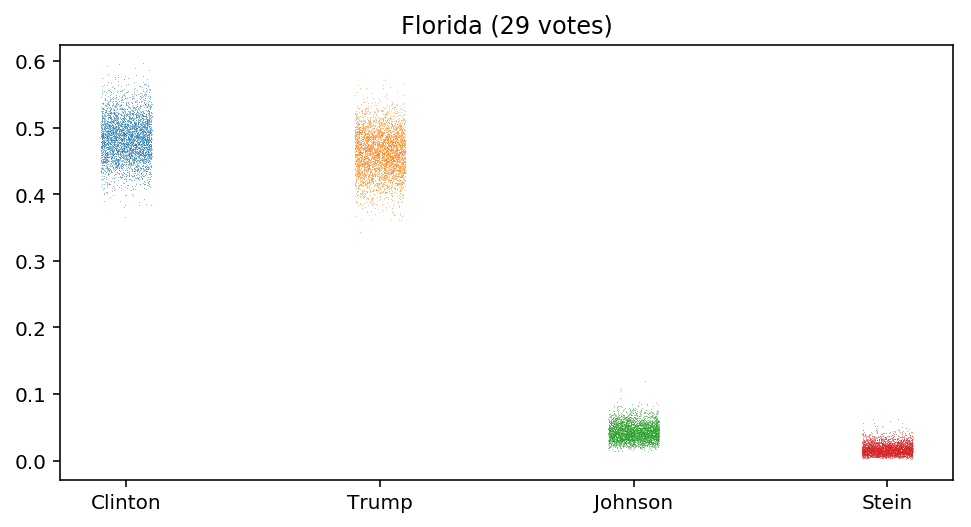

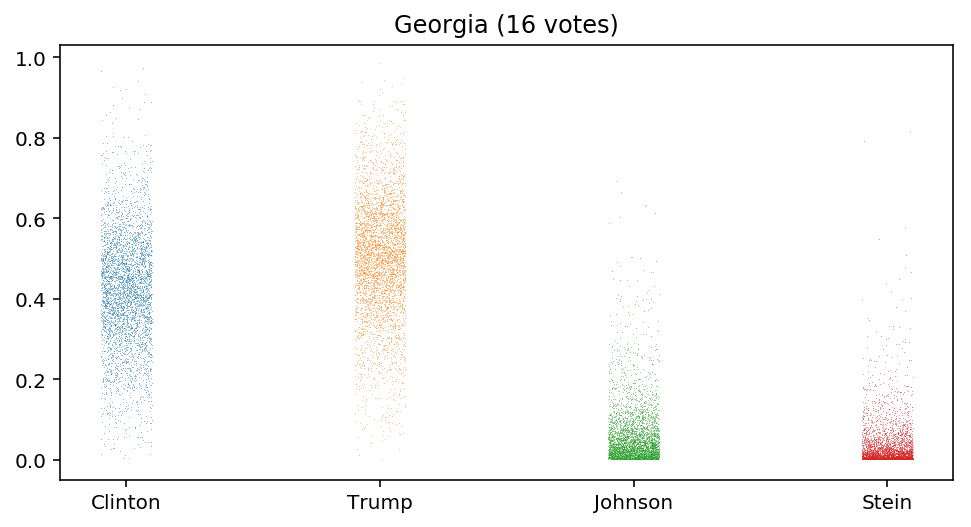

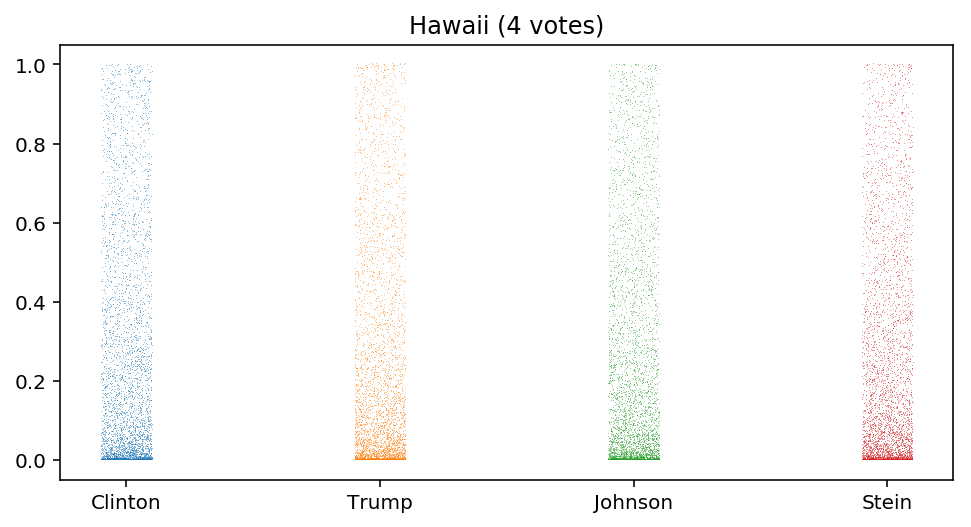

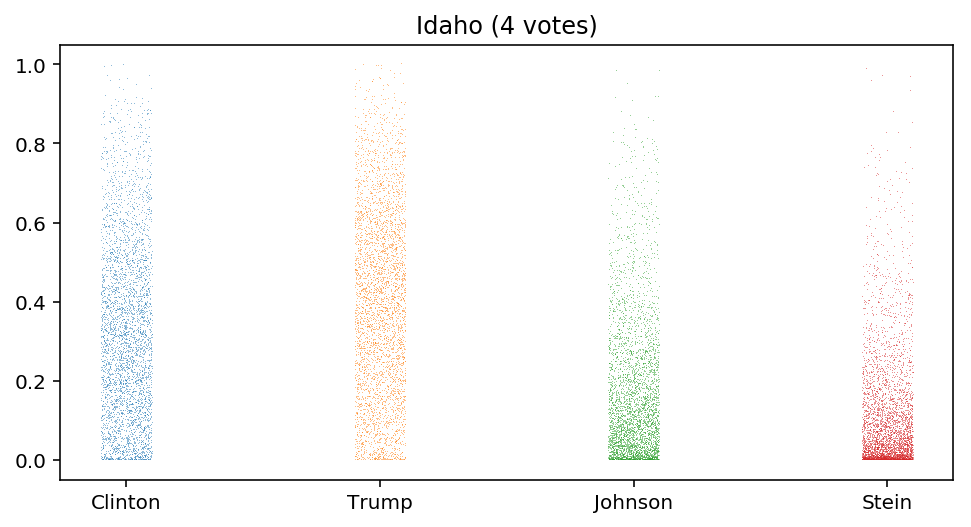

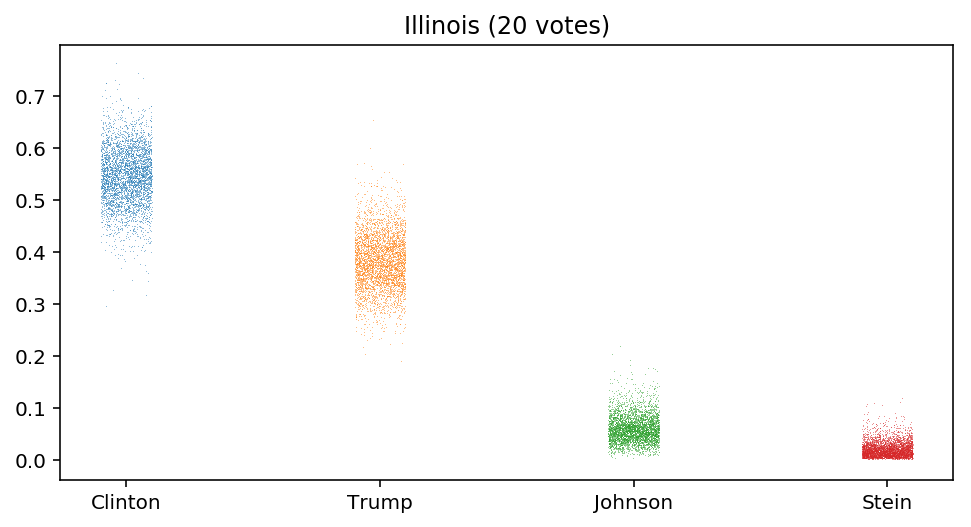

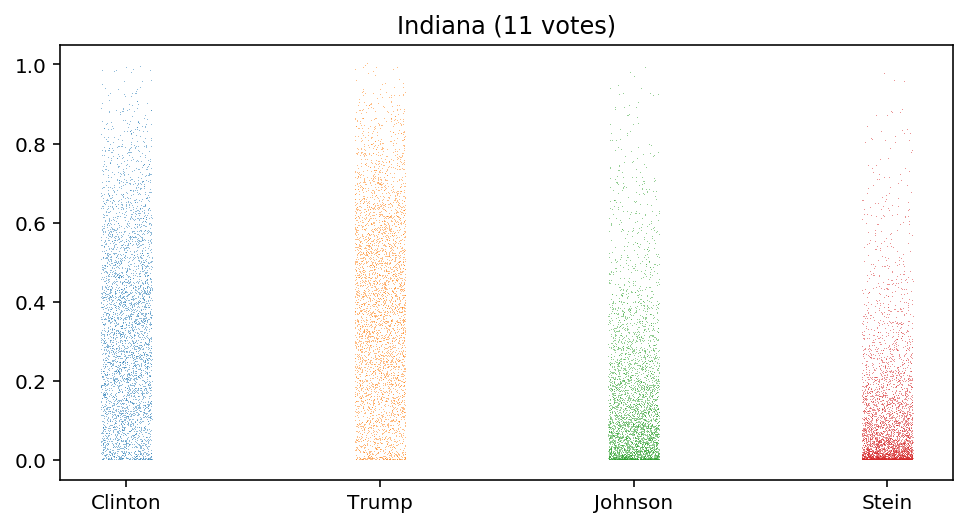

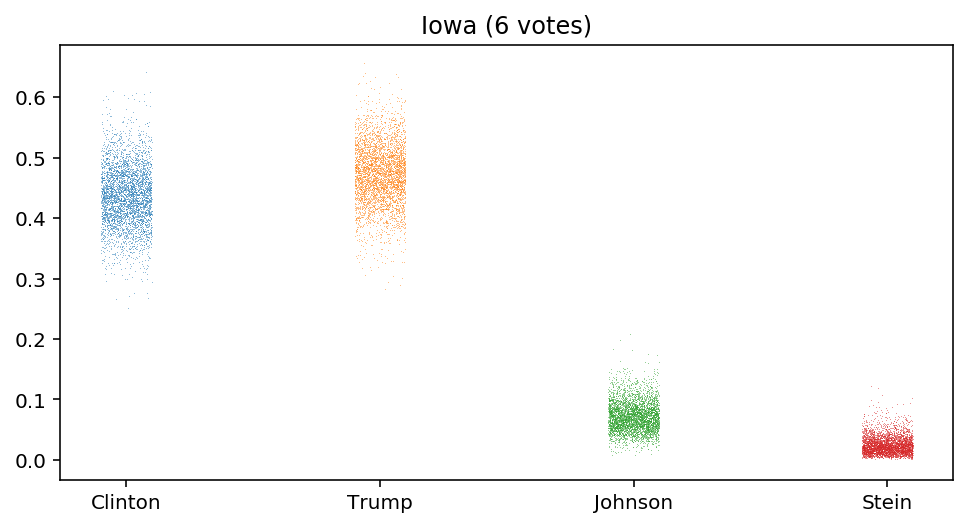

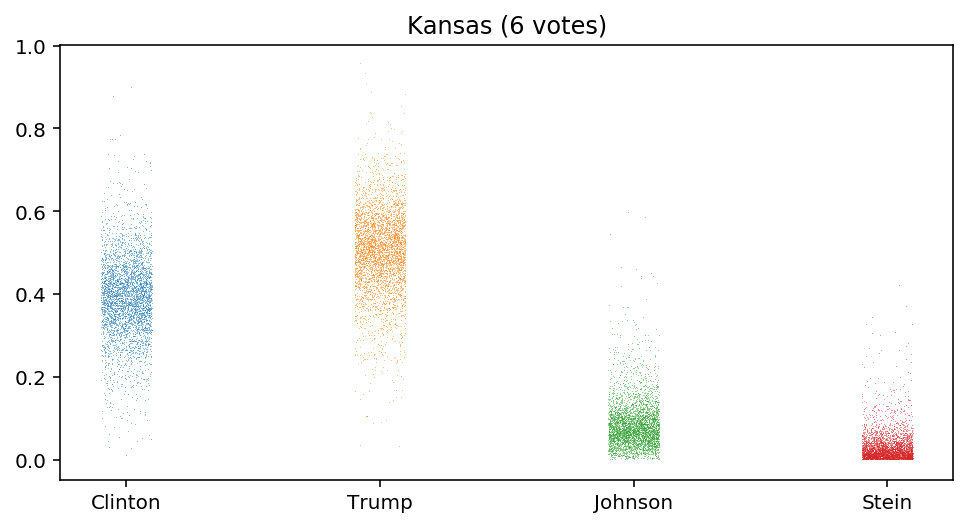

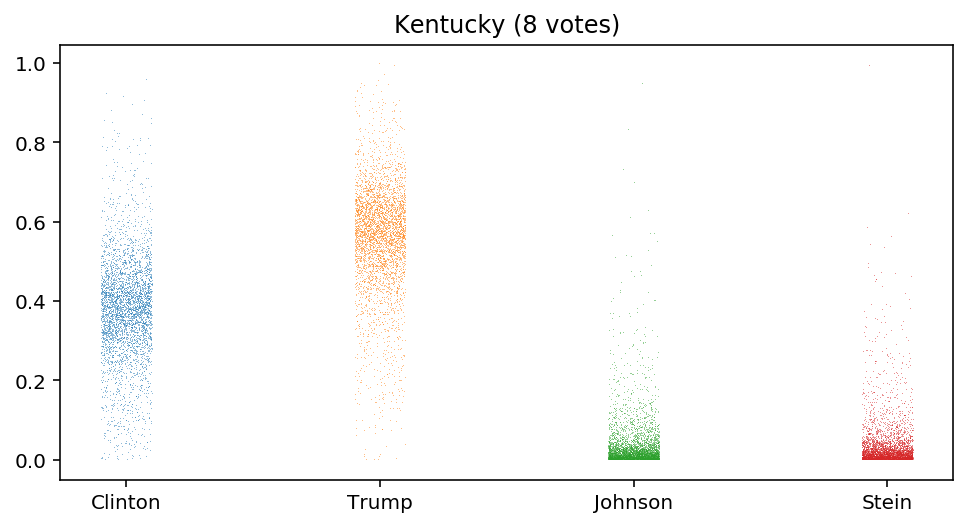

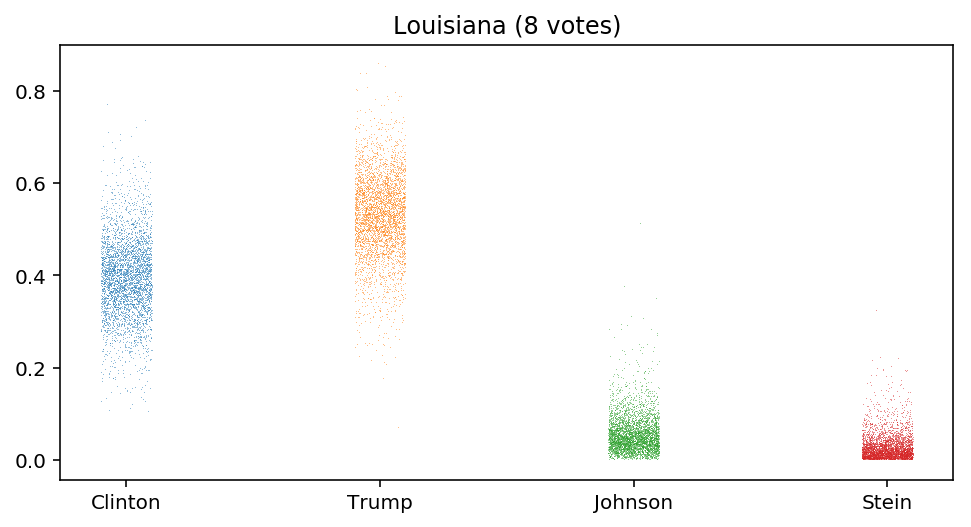

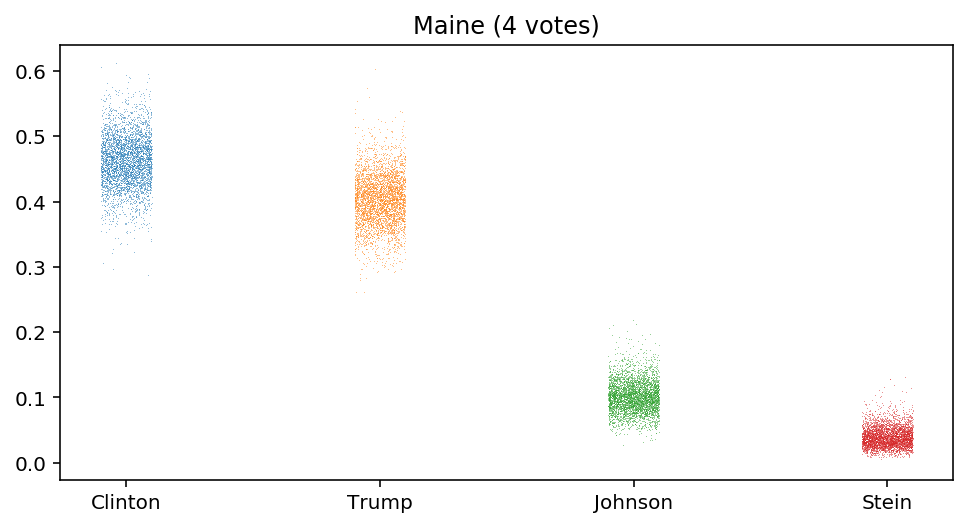

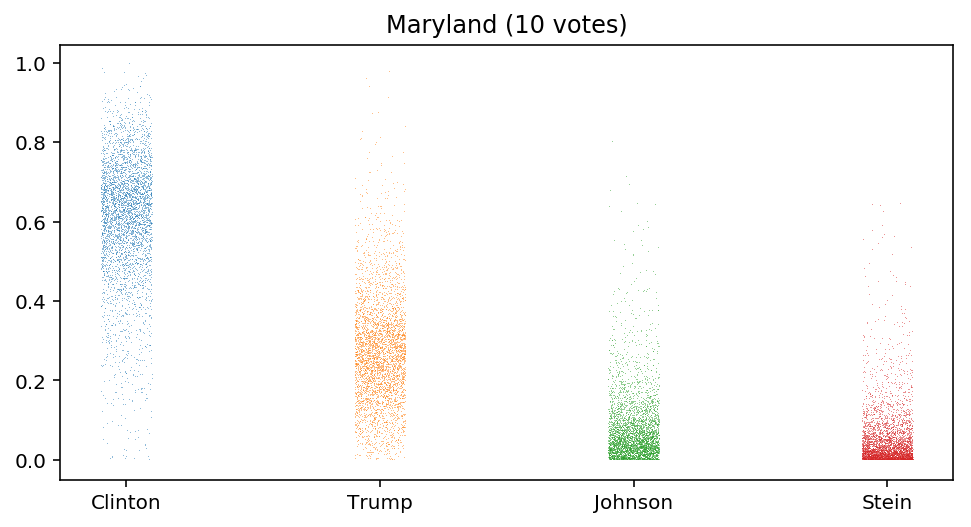

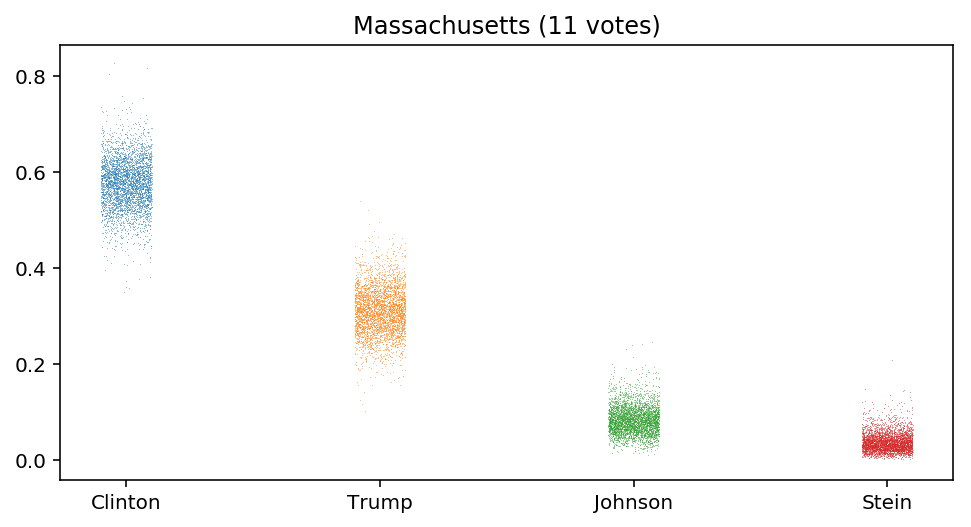

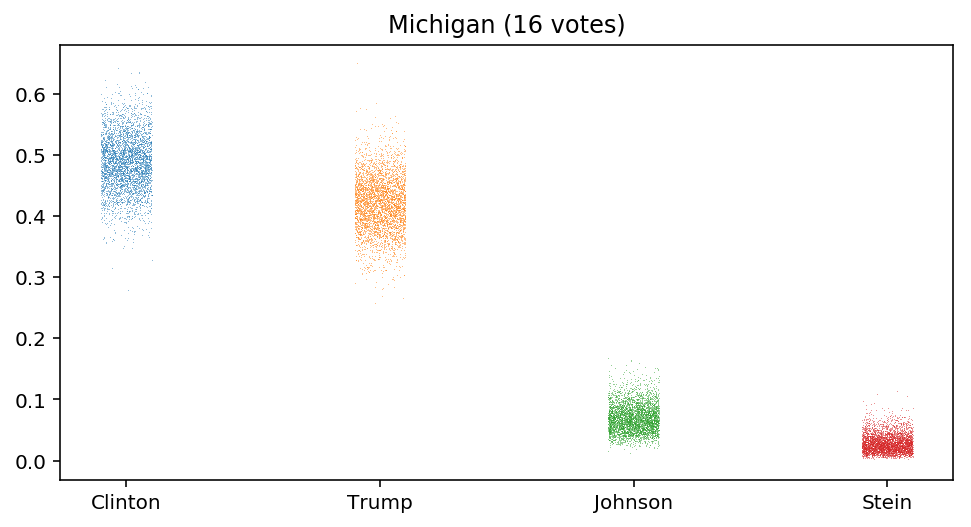

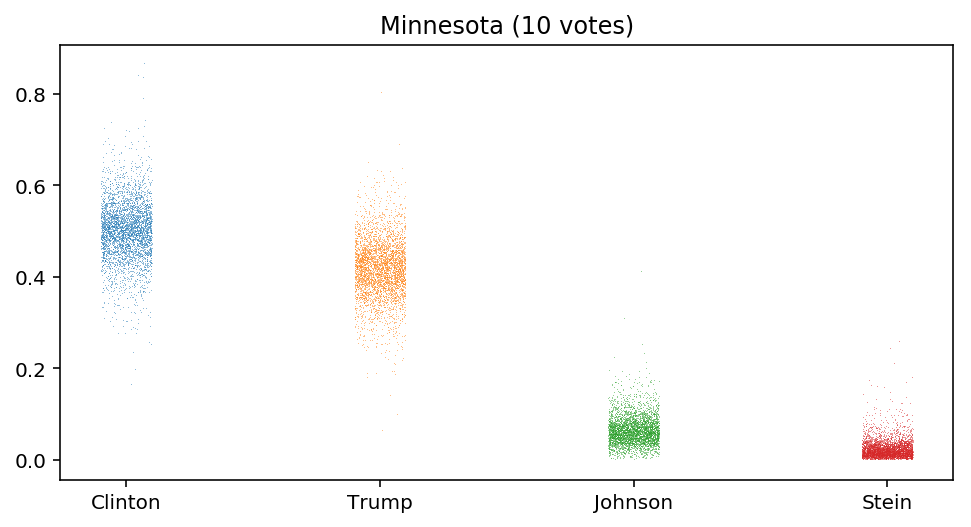

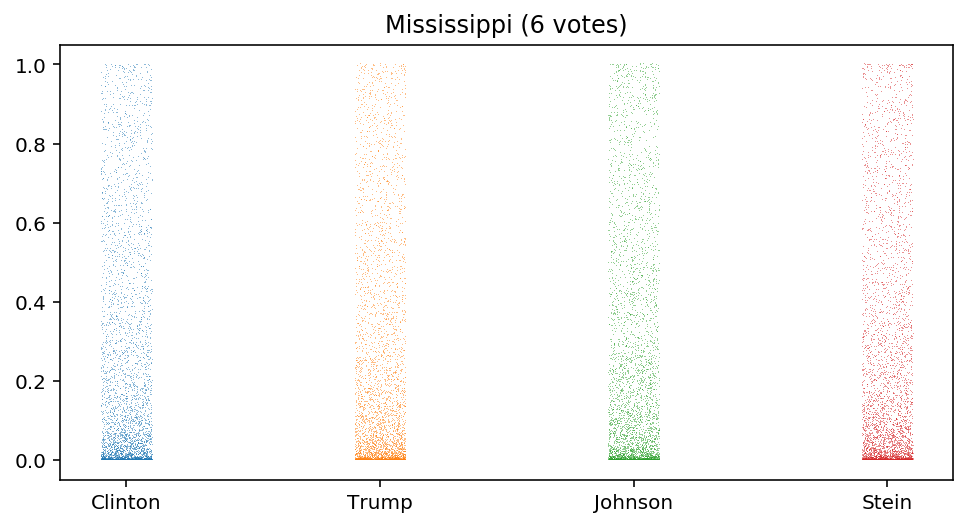

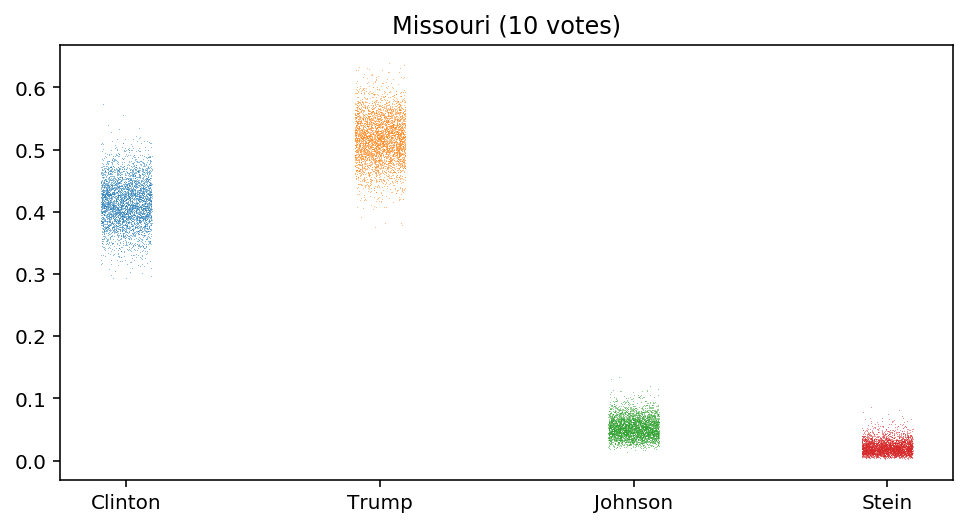

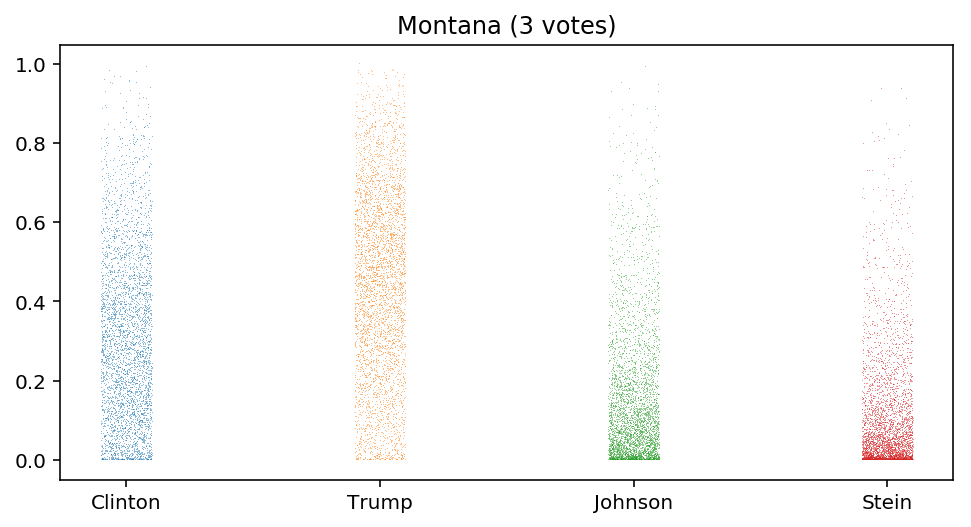

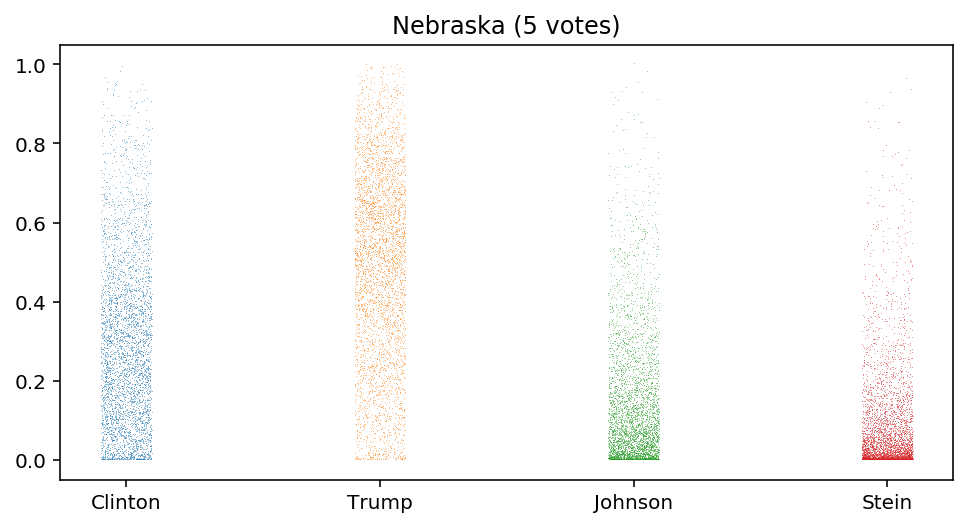

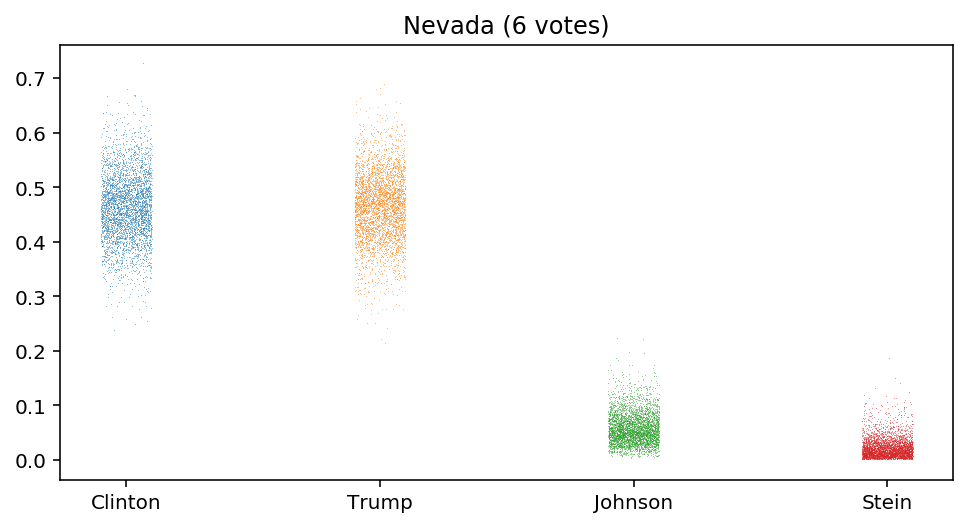

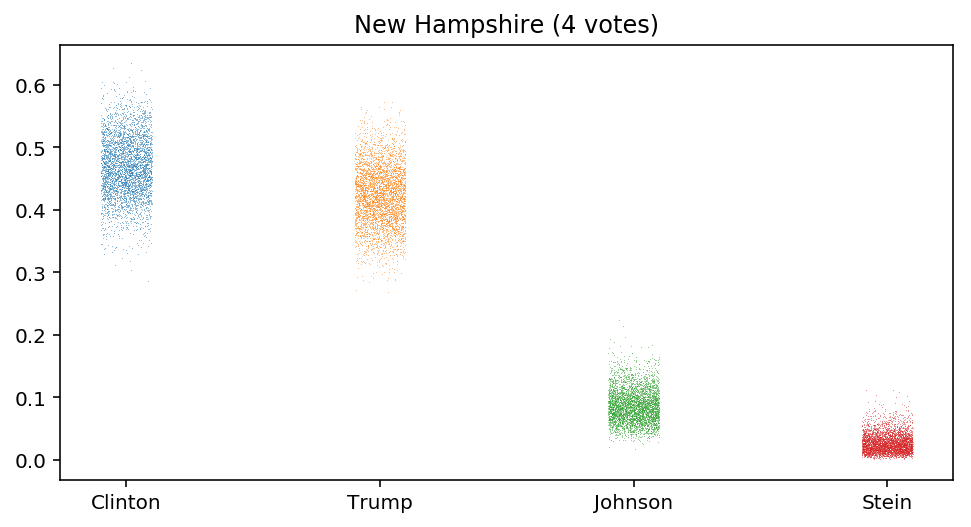

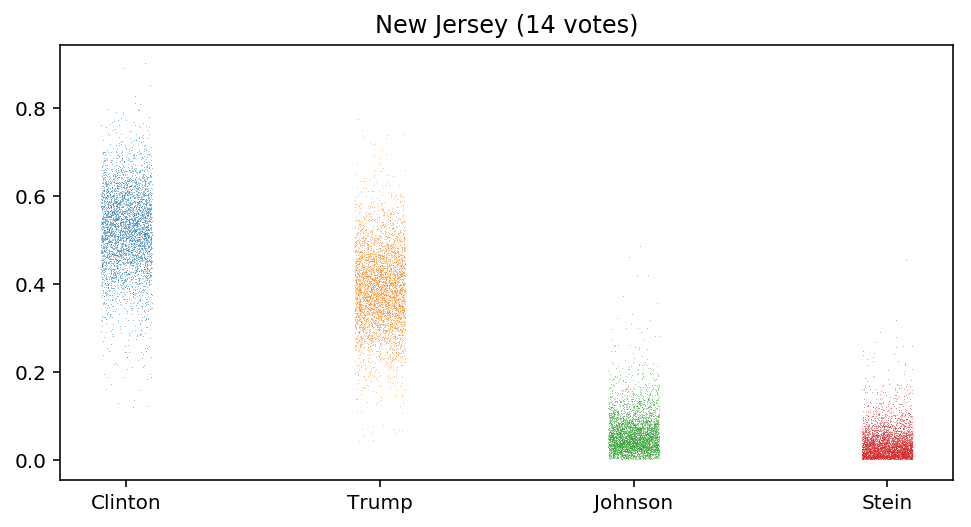

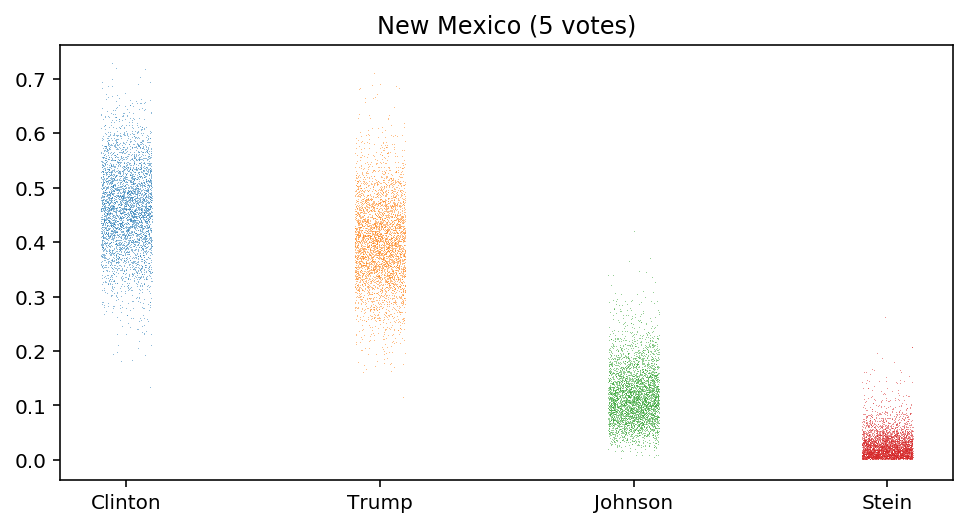

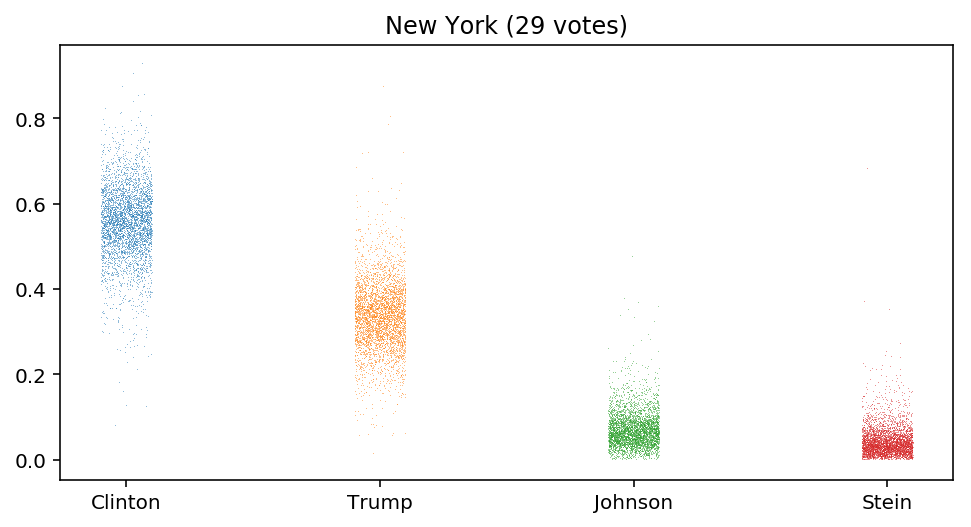

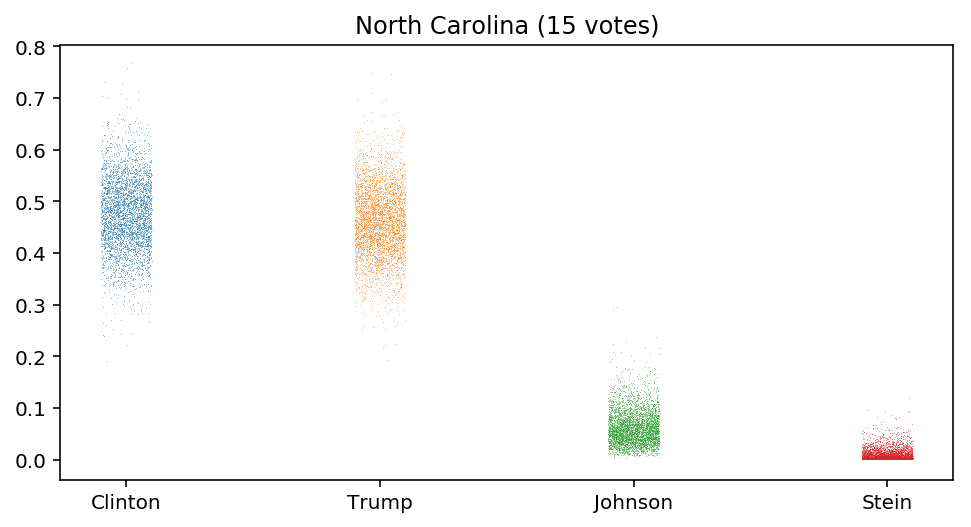

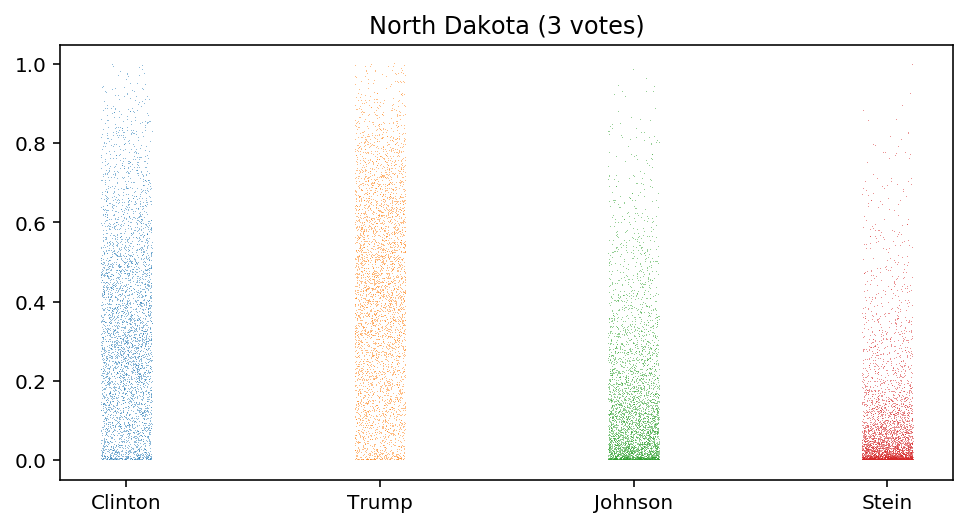

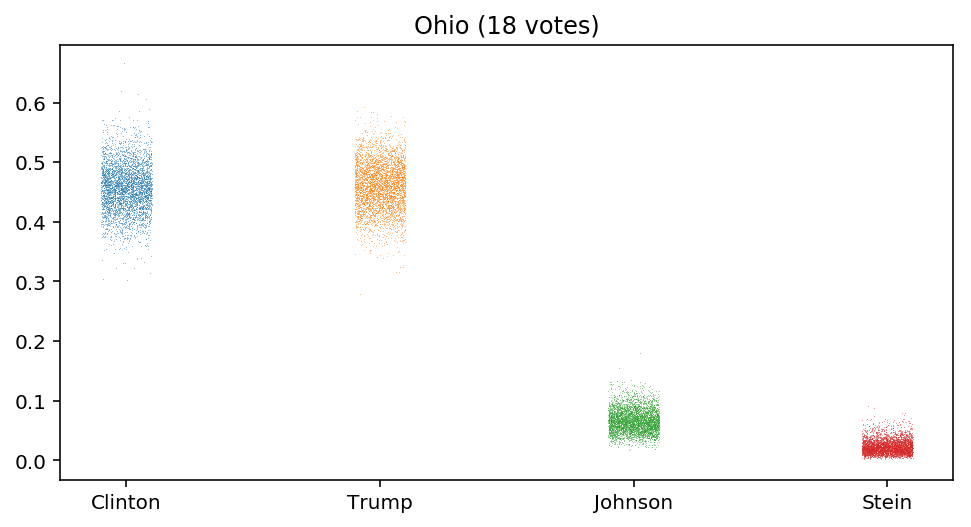

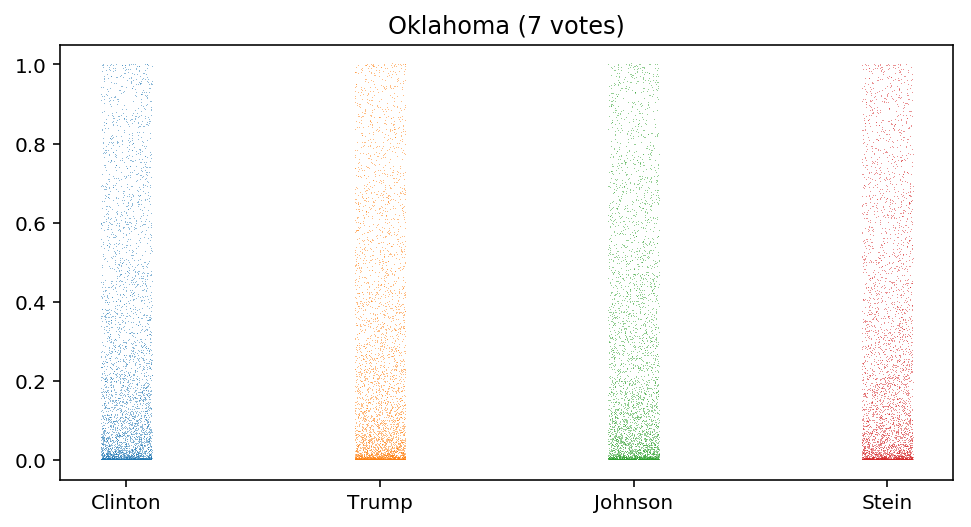

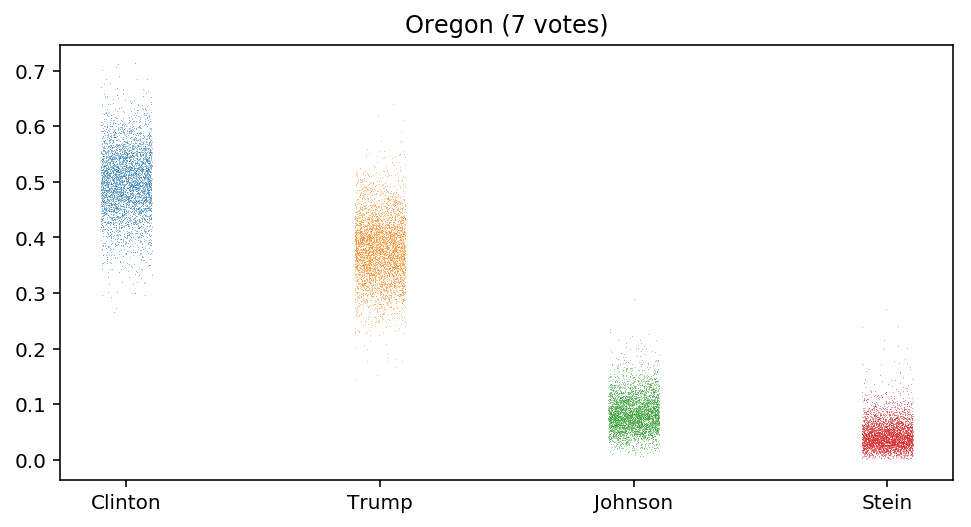

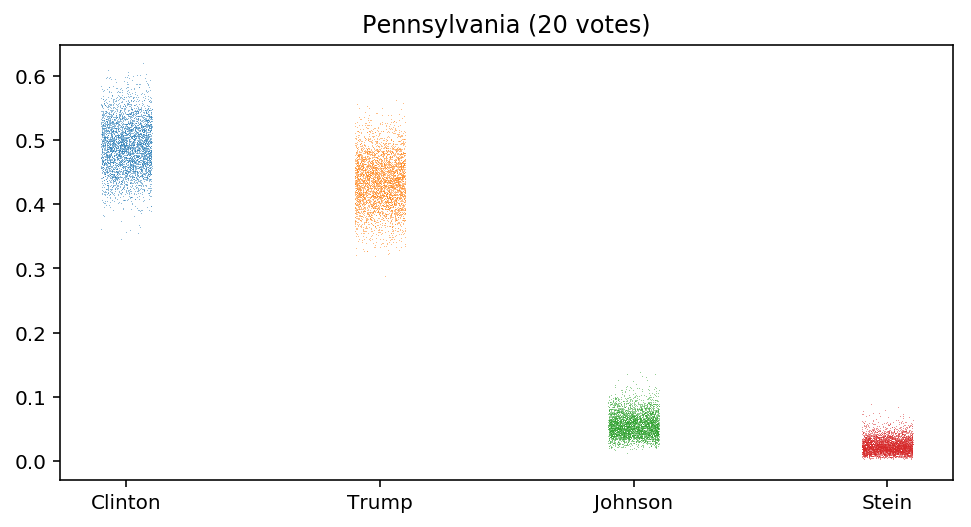

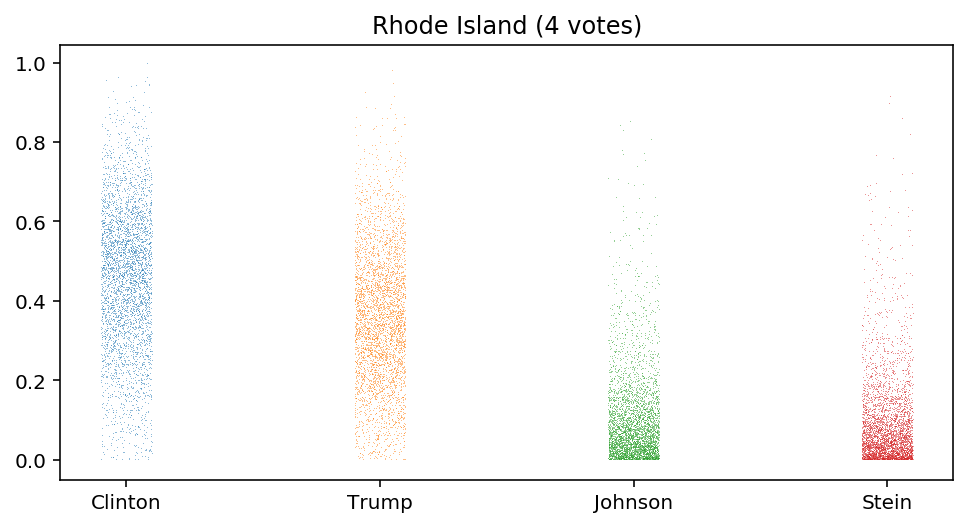

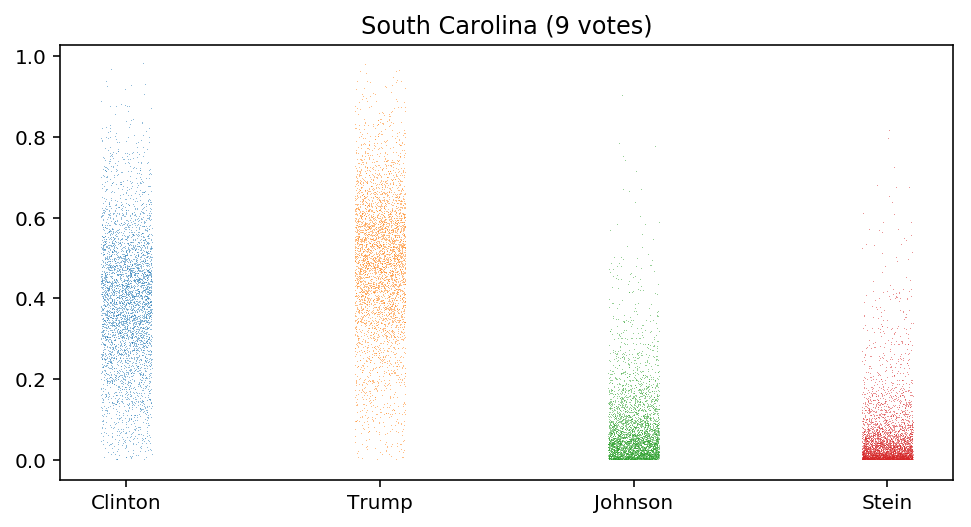

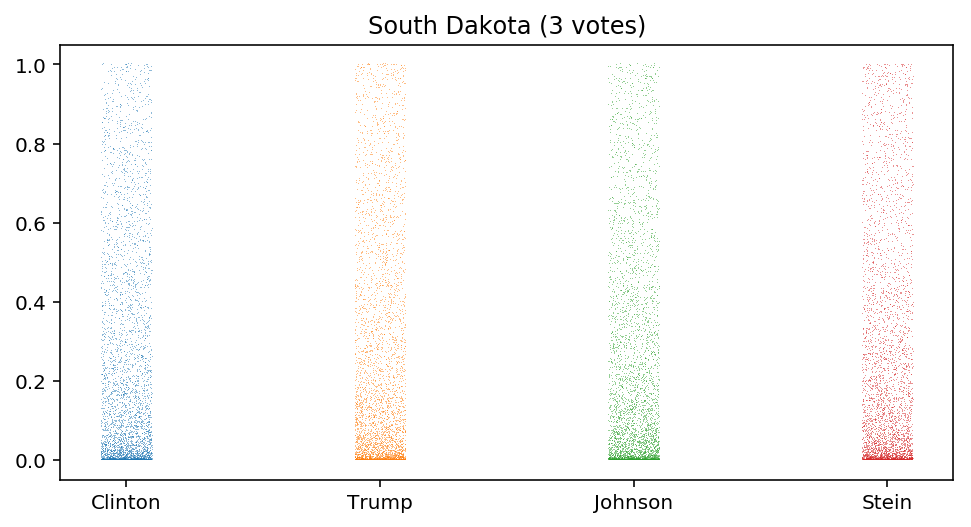

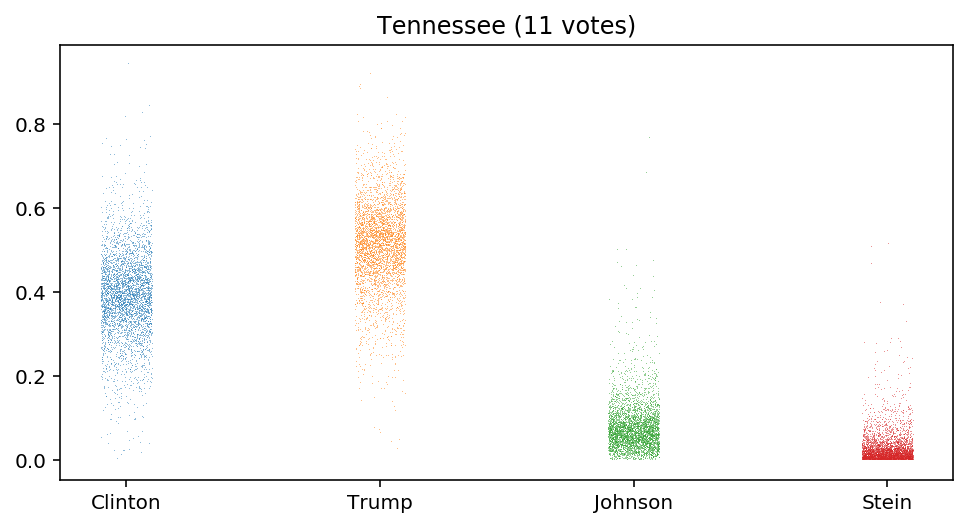

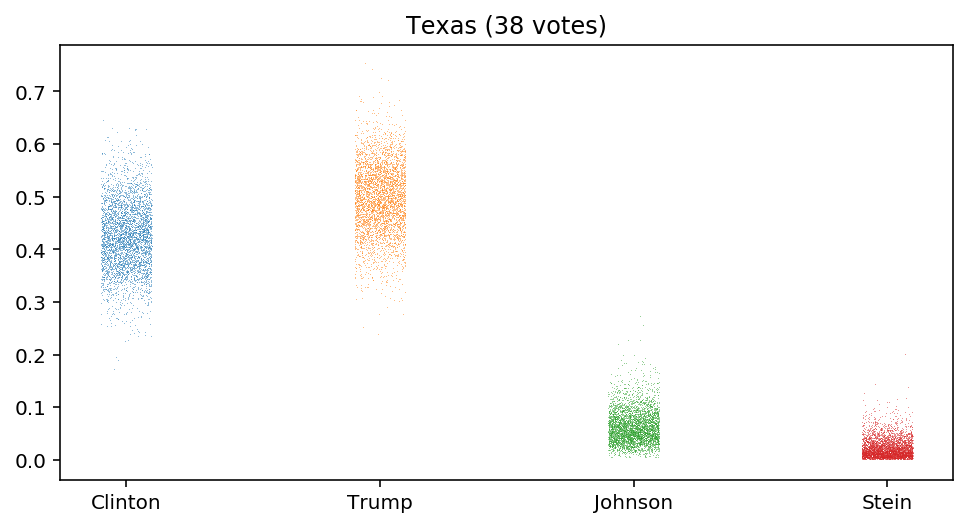

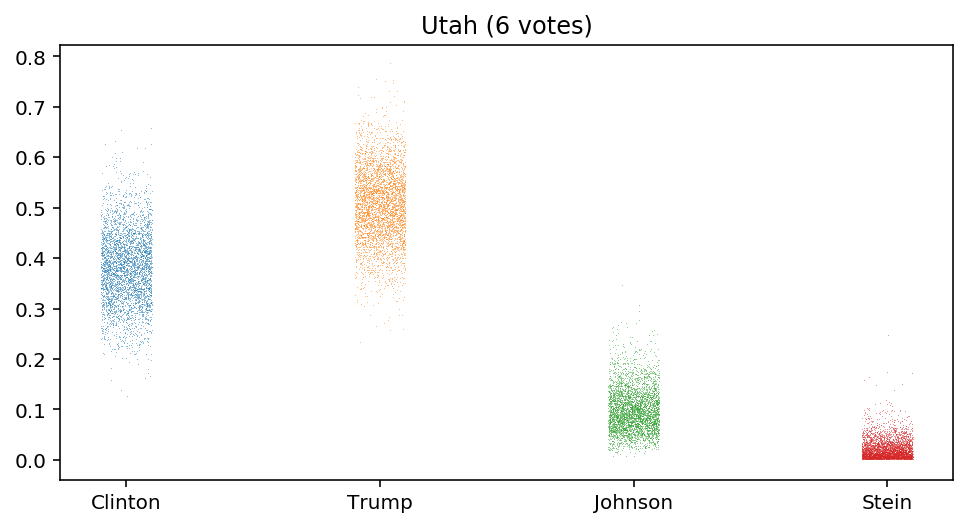

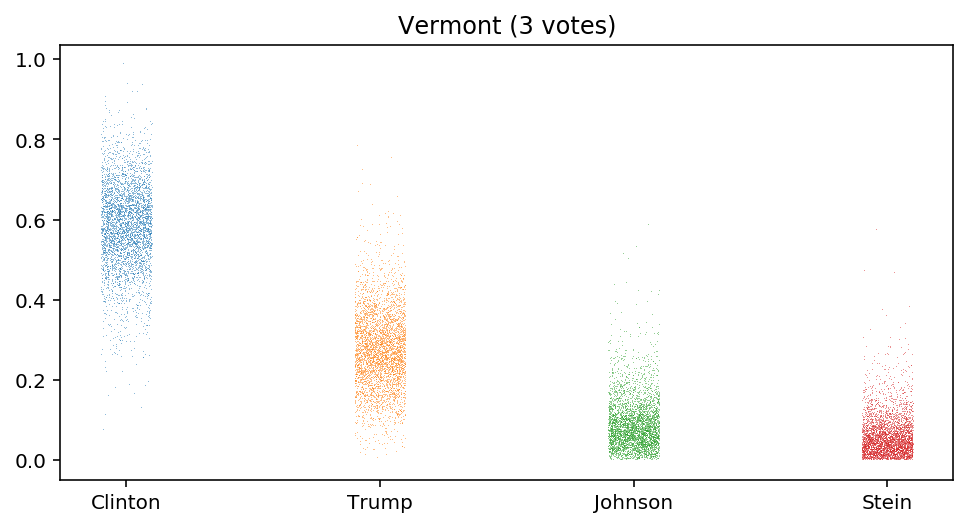

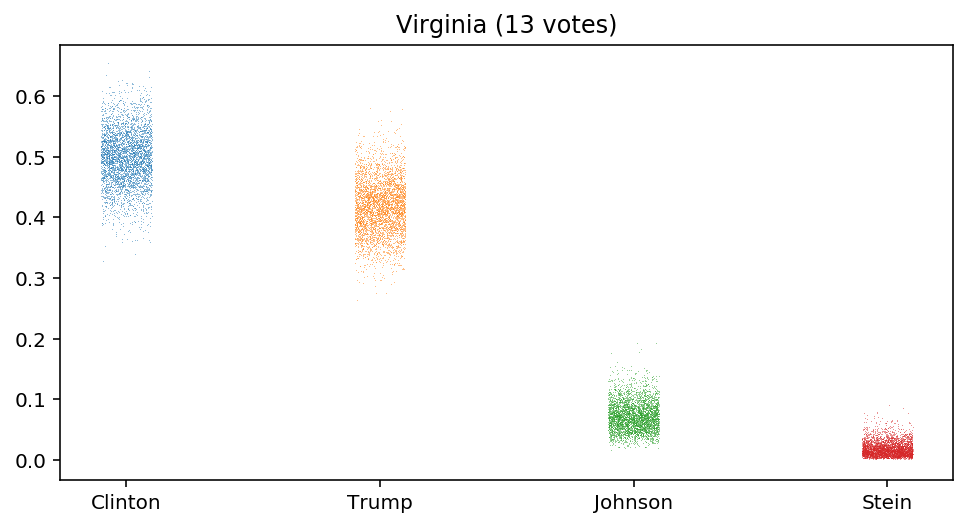

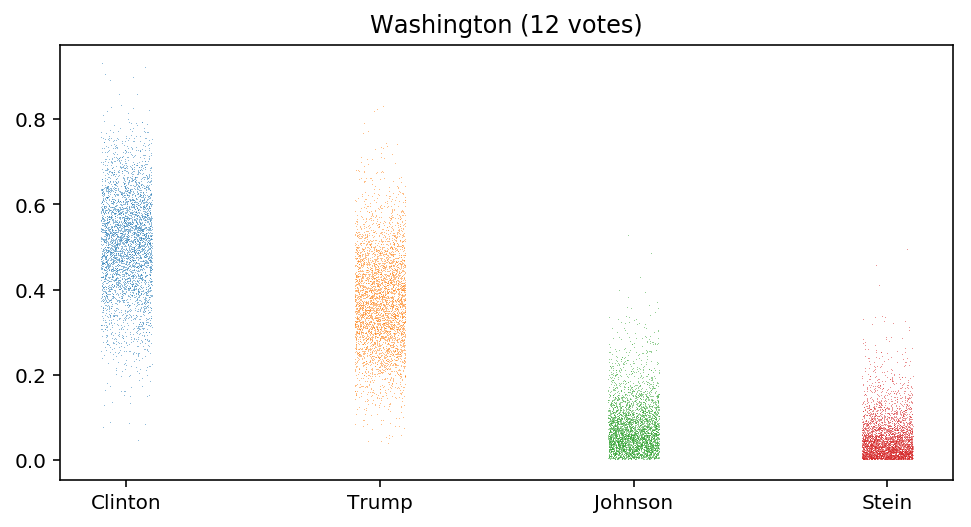

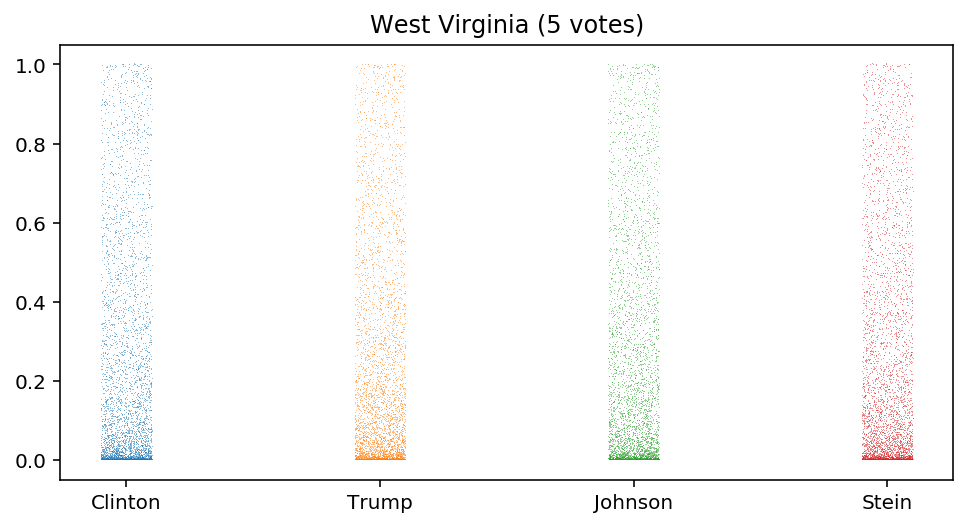

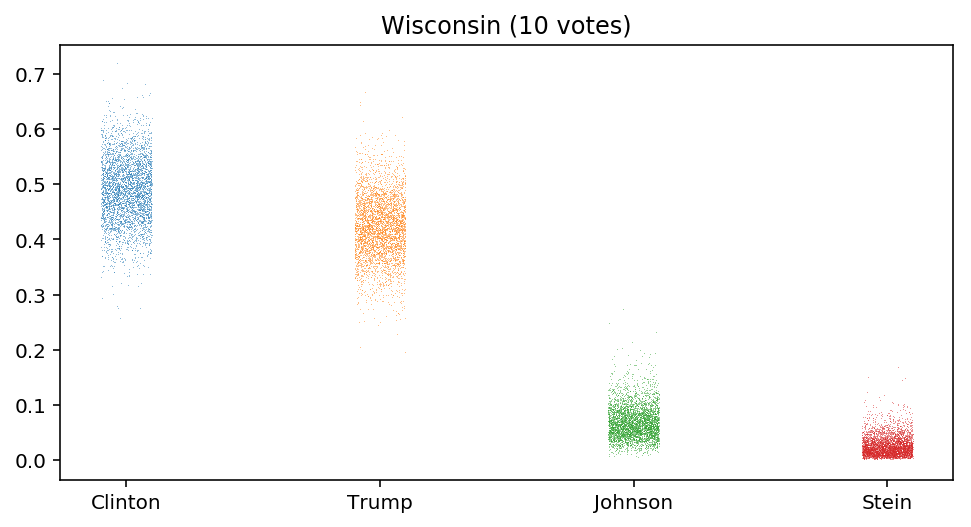

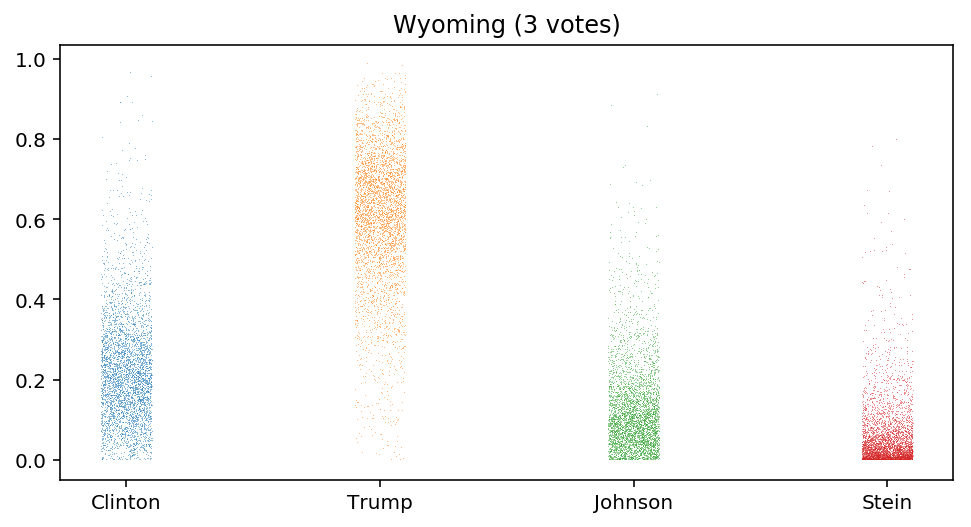

In [5]:
# Generating predictive samples using SciPy
for state in states:
    samples = results[state].extract()
    alpha = samples['alpha']
    p_predicted = np.empty(alpha.shape)
    for i in range(alpha.shape[0]):
        p_predicted[i] = stats.dirichlet.rvs(alpha[i])
    plt.figure(figsize=(8, 4))
    for i in range(4):
        plt.plot(stats.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), p_predicted[:,i], ',', alpha=0.5)
    plt.title(state + ' (' + str(electoral_votes[state]) + ' votes)')
    plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.show()

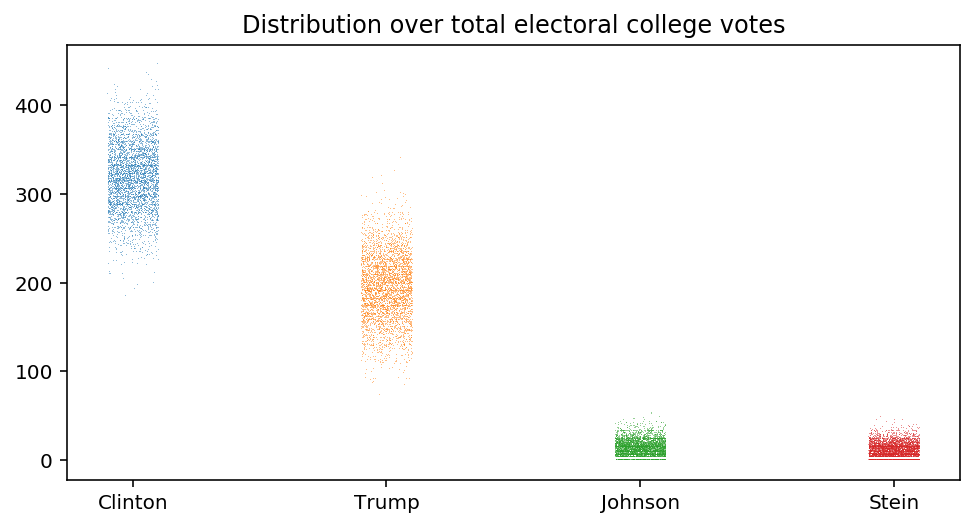

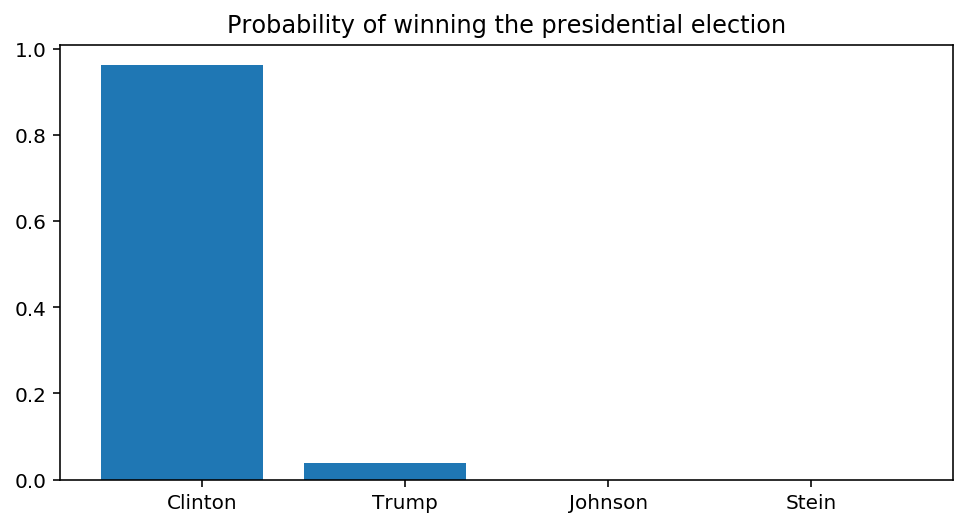

In [6]:
# Generating winner simulation using SciPy
samples = {state: results[state].extract() for state in states}
total_votes = np.zeros((4000, 4))
overall_winner = np.zeros(4000)
for s in range(4000):
    for state in states:
        alpha = samples[state]['alpha'][s]
        p_predicted = stats.dirichlet.rvs(alpha)
        winner = p_predicted.argmax()
        total_votes[s, winner] += electoral_votes[state]
    overall_winner[s] = total_votes[s].argmax()

plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), total_votes[:,i], ',', alpha=0.5)
plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.title('Distribution over total electoral college votes')

plt.figure(figsize=(8, 4))
plt.hist(overall_winner, bins=[-0.5, 0.5, 1.5, 2.5, 3.5], width=0.8, align='mid', density=True)
plt.xticks([0, 1, 2, 3], ['Clinton', 'Trump', 'Johnson', 'Stein'])
plt.title('Probability of winning the presidential election')
plt.show()